<a href="https://colab.research.google.com/github/PillB/Coursera_Capstone/blob/master/Desaf%C3%ADo_CrossValidation_%2BPablo_%2BIllescas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Credit Card Transactions
### Data de Fraude en operacione con tarjeta bancaria
#### source: https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions?select=User0_credit_card_transactions.csv

## Objetivo:
El objetivo del proyecto sería utilizar la información de la base de datos de operaciones de tarjetas bancarias para poder detectar fraudes.

## Contexto comercial:
El fraude es un factor que impacta negativamente al negocio bancario y a los comercios por el costo que genera al representar un robo de dinero de la empresa y del cliente, también genera un impacto negativo en la satisfacción del cliente y la experiencia y confianza general en la empresa. Por todos estos motivos es relevante desarrollar un sistema automatizado predictivo que permita detener estas operaciones fraudulentas antes que se concreten, en particular dado que según indican las tendencias se está popularizando cada vez más el uso de bots y otras técnicas automatizadas y masivas por parte de los criminales para realizar operaciones fraudulentas y desplegar malware bancario.

## Problema comercial:
El problema clave comercial respecto al fraude es detectar la mayor cantidad de casos fraudulentos (es decir detener la mayor cantidad de fraude) con el menor falso positivo posible (operaciones genuinas declinadas) ya que aunque el fraude es un problema relevante para la empresa bancaria en monto total, es un evento infrecuente en comparación con el enorme volumen de operaciones genuinas por lo que un modelo con baja precisión puede costar más en términos de la fricción generadas a los clientes (por ej. si declinan una operación genuina por lo cual el cliente opera con la competencia). Entonces será una métrica clave para este modelo la precisión o un F-score u otra métrica donde se ponderen estos factores.

## Hipótesis:
Algunas de las hipótesis clave que deberíamos testear para dar más luces a esta problemática e informar al modelo del contexto de fraude serían:

- tratar de identificar si los montos de fraude están concentrados en algún rango de valores (por ejemplo si se utilizan montos altos para vaciar las cuentas o montos chicos para pasar desapercibidos).
- identificar si existe algúna zona geográfica (en nuestro caso mediante la variable de estado 'Merchant State' que tenga una particular concentración de fraude).
- identificar si el fraude se comporta similarmente cada mes, es decir si en algún mes en particular podría haber montos de fraude mas altos con mayor frecuencia.
- identificar si el fraude tiene algún tipo de estacionalidad y ocurre con más frecuencia en un mes o periodo del año

In [1]:
import pandas as pd
data_fraude = pd.read_csv("User0_credit_card_transactions.csv")

In [2]:
data_fraude.shape

(19963, 15)

In [3]:
data_fraude.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [4]:
data_fraude.Amount = data_fraude.Amount.str.replace('$', '')
data_fraude.Amount = data_fraude.Amount.astype("float")

<ipython-input-4-857db0c322e1>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_fraude.Amount = data_fraude.Amount.str.replace('$', '')


In [5]:
data_fraude.columns = ['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Fraud']

In [6]:
data_fraude.Fraud.unique()

array(['No', 'Yes'], dtype=object)

In [7]:
data_fraude.Fraud = data_fraude.Fraud.replace({"No": 0, "Yes": 1})
data_fraude["Fraud"] = data_fraude["Fraud"].astype("category")

In [8]:
data_fraude.Fraud.unique()

[0, 1]
Categories (2, int64): [0, 1]

## EDA y Recomendaciones

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use("bmh")

<Axes: xlabel='Amount', ylabel='Count'>

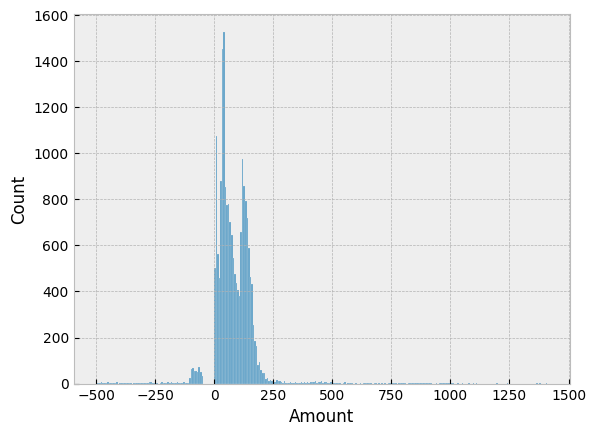

In [10]:
sns.histplot(data=data_fraude, x="Amount")

En esta gráfica del histograma del monto de operaciones podemos notar que aunque la mayoría de datos está englobado entre los montos de 0 a 250, se pueden notar dos observaciones que ameritarían mayor investigación para su tratamiento. En primer lugar vemos montos negativos, lo cual es raro en el caso donde son operaciones, es decir: ¿Pueden haber compras negativas o son errores de data-entry?¿O serán operaciones de devoluciones que se han incluido en la data? Si son errores de data-entry habría que tomar acción para corregirlo ya sea viendo si se elimina la data o quizás se descubra una lógica que indique que serían valores positivos y no negativos. por otro lado si son operaciones de devolución amerita preguntar si son pertinentes para el análisis ya que el fraude ocurre cuando una persona que no es el cliente hace una compra, las devoluciones las realiza un operario del banco por lo que estas operaciones jamas serían fraudulentas por lo que deberían quitarse de la data. Para poder responder a estas preguntar habría que revisar el caso complementario a la data en Kaggle para entender mejor los datos. También vemos que existe una columna de errores de data, si los valores negativos correlacionan con los casos donde cumple el flag de errores podríamos intuir que son errores de data entry.

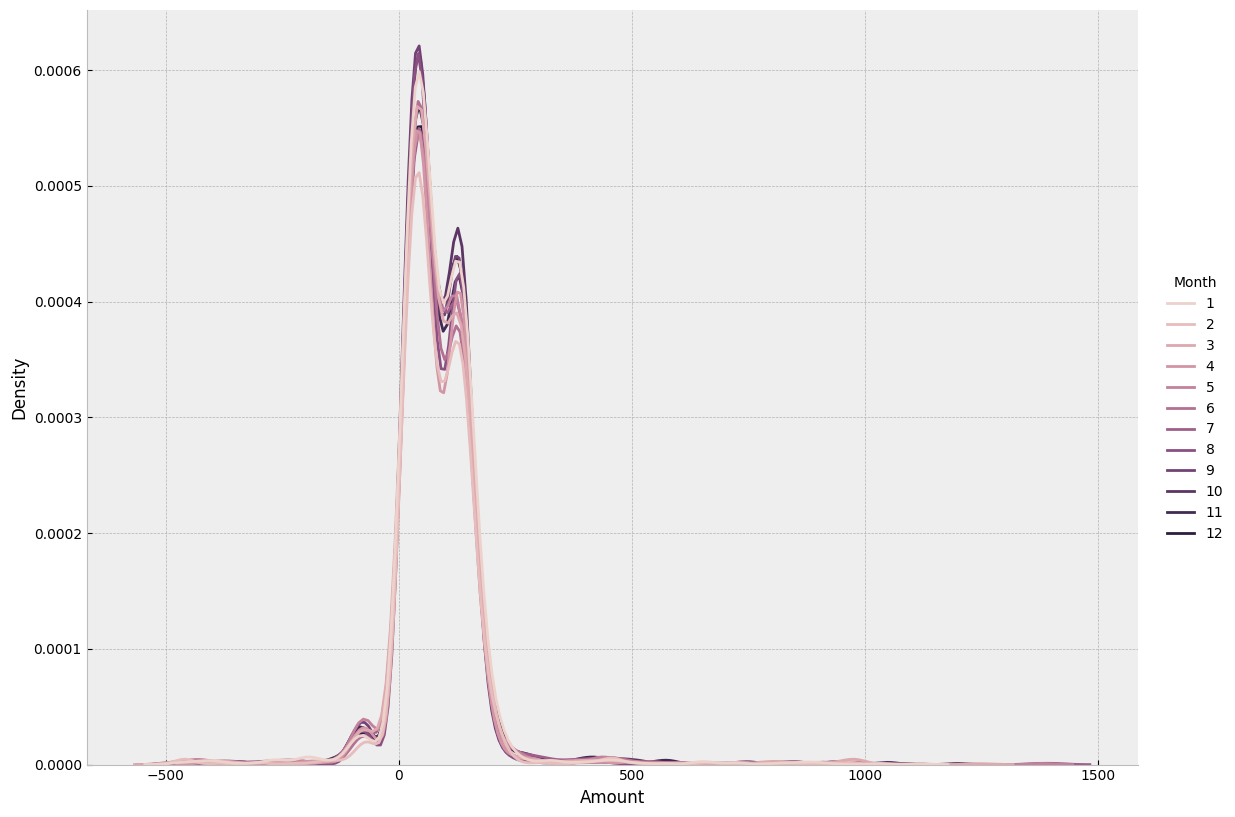

In [11]:
sns.displot(data=data_fraude, x="Amount", hue="Month", kind="kde",height=8.27, aspect=11.7/8.27)

En esta gráfica vemos la distribución de los montos de fraude de cada mes. Más adelante veremos que ciertos meses tienen mayores montos totales de operaciones realizadas, sin embargo con este gráfico podemos ver que el comportamiento general de los montos intra-mes es similar.

In [12]:
data_fraude.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Fraud'],
      dtype='object')

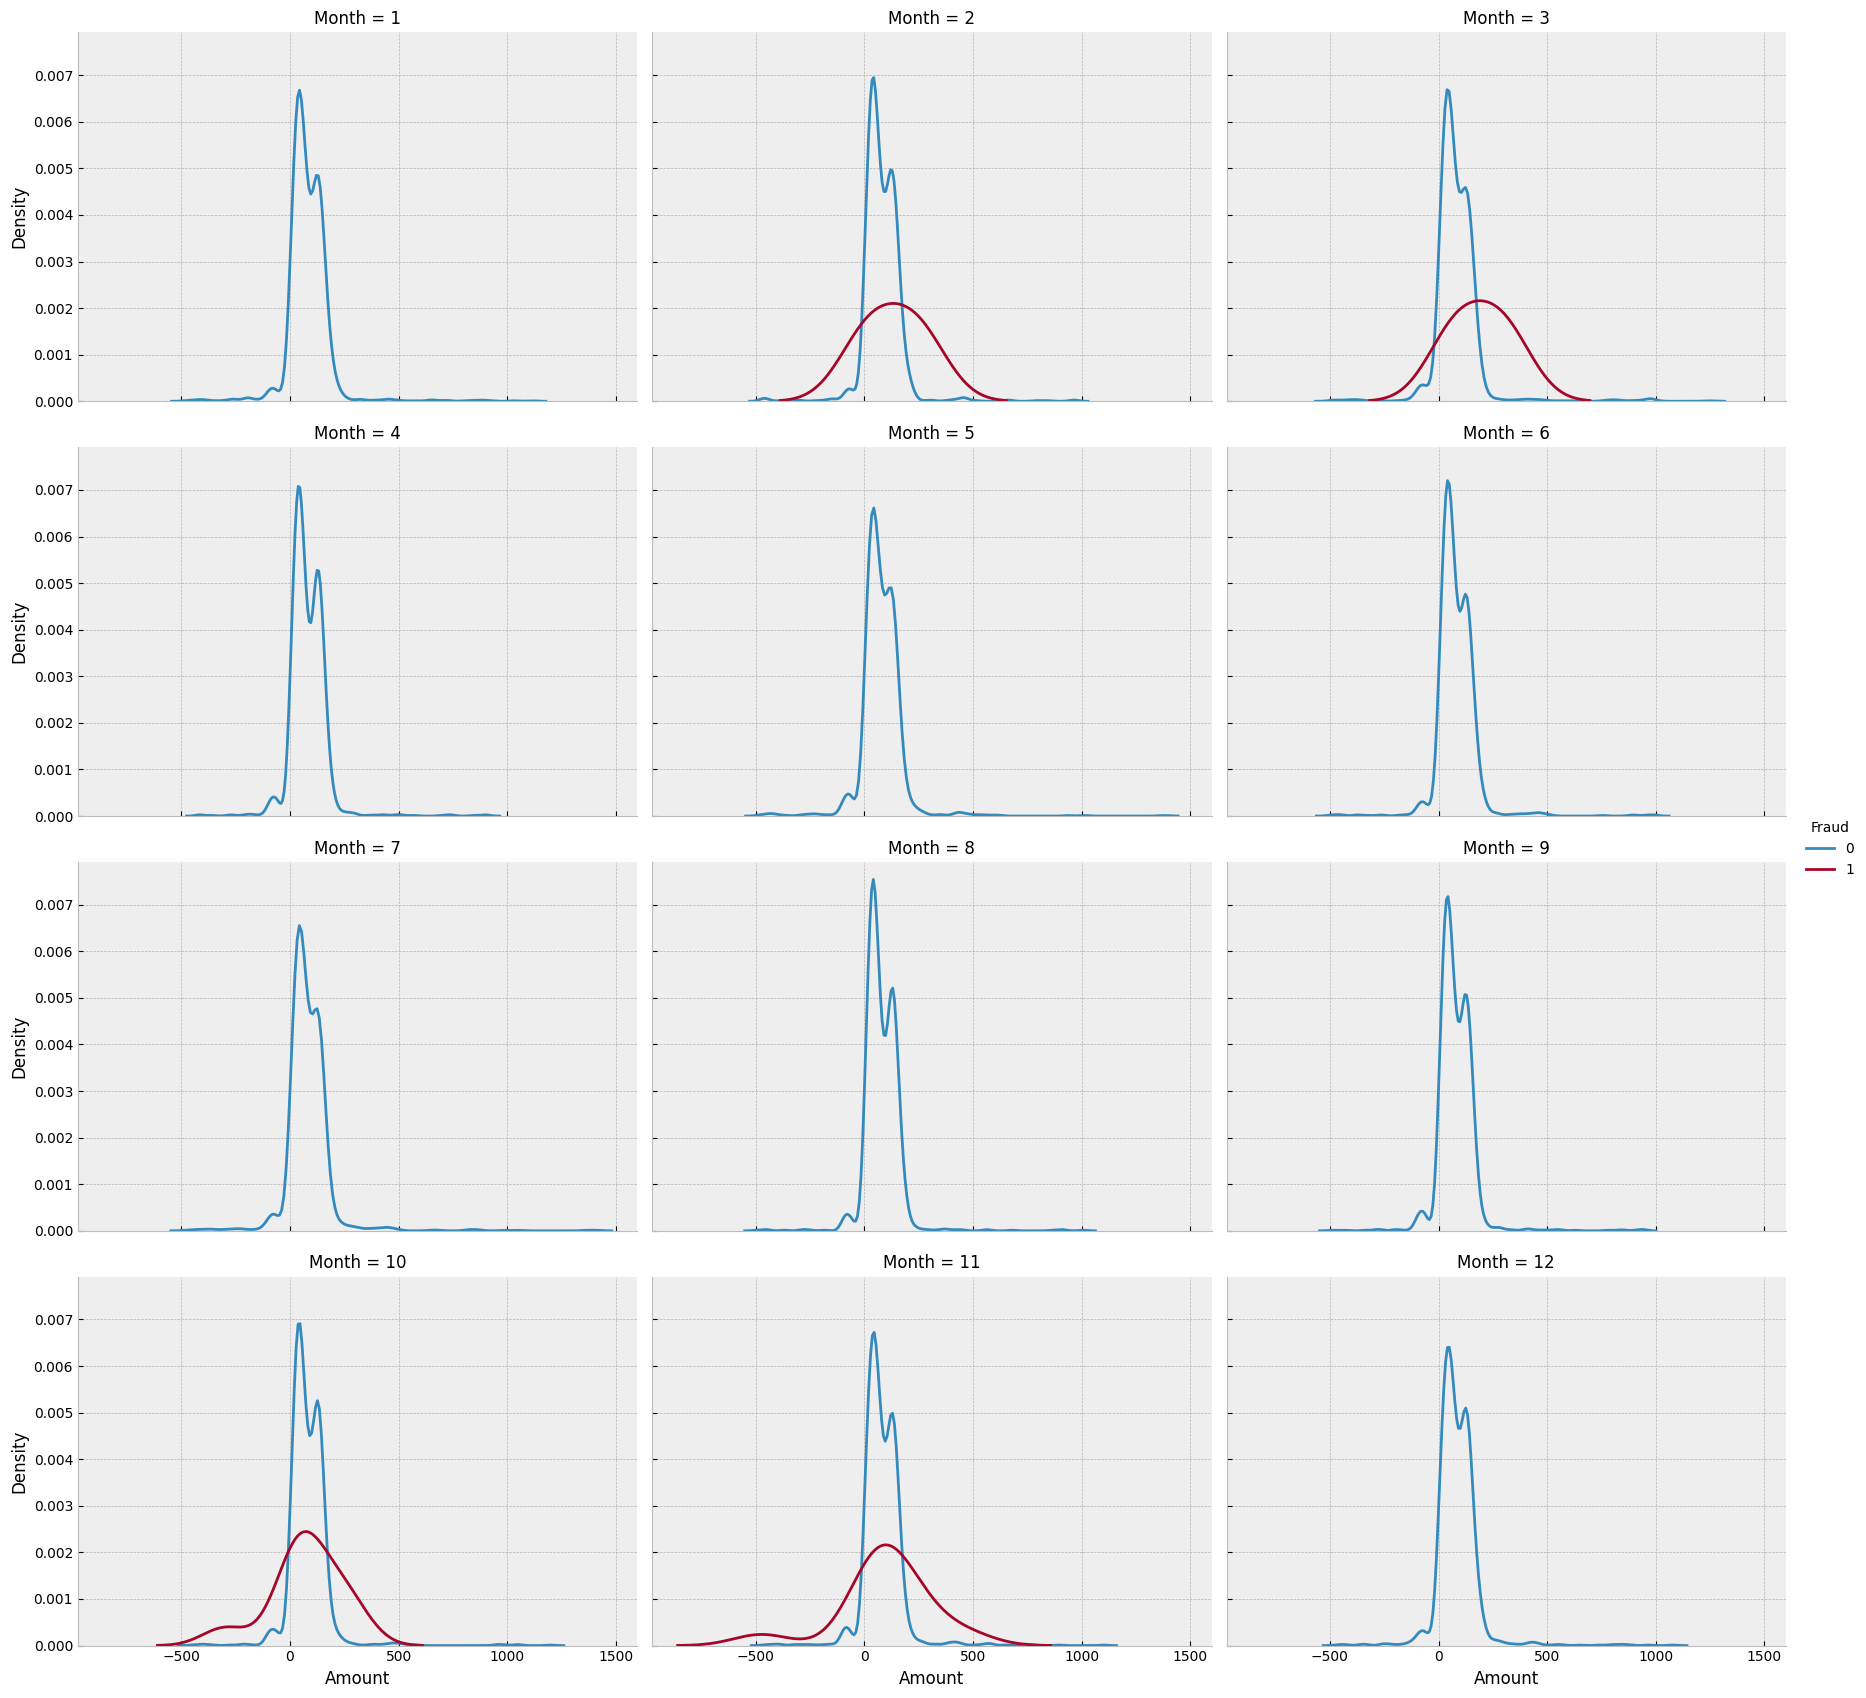

In [13]:
facet = sns.FacetGrid(data_fraude,col="Month", hue="Fraud", height=4.27, aspect=11.7/8.27, col_wrap=3)
facet.map(sns.kdeplot, "Amount")
facet.add_legend()
plt.show()

In [14]:
data_fraude[["Month","Fraud","Amount"]].groupby(["Month","Fraud"]).mean()

Amount
Month Fraud            
1     0       82.798542
      1             NaN
2     0       80.707078
      1      133.315000
3     0       82.645339
      1      189.895000
4     0       80.724680
      1             NaN
5     0       77.583537
      1             NaN
6     0       81.126790
      1             NaN
7     0       82.188340
      1             NaN
8     0       79.320363
      1             NaN
9     0       78.951198
      1             NaN
10    0       82.105940
      1       72.626000
11    0       82.103616
      1       95.738462
12    0       84.672461
      1             NaN

En esta gráfica podemos ver la distribución de los montos fraudulentos y no fraudulentos para cada mes. Vemos que existen más casos de fraude en proporción al total de operaciones en los meses de febrero, marzo, octubre y noviembre. Esto lo podremos reconfirmar en las siguientes gráficas donde vemos la evolución mensual de las operaciones y las operaciones separadas por fraude (1) y no fraude (0). Podemos ver que en los meses con suficientes operaciones fraudulentas que se puede notar una distribución estimada (según el kde) los fraude se comportan de manera normal alrededor de los 75 usd aproximadamente en octubre y noviembre. El promedio es mayor en los fraude en febrero y marzo rondando los 130+. En octubre y noviembre notamos un pico de montos negativos alrededor de -500.

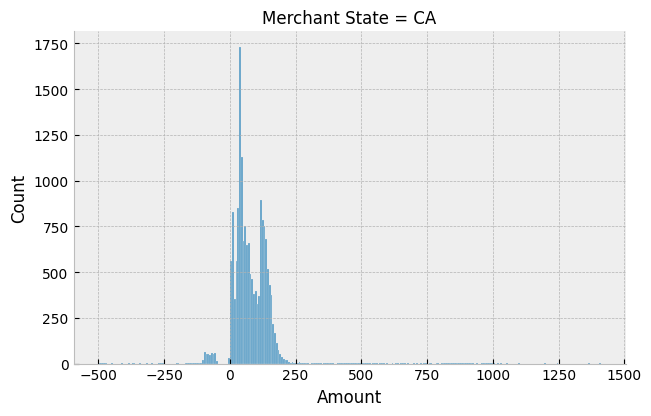

In [15]:
g = sns.FacetGrid(data_fraude.loc[data_fraude["Merchant State"] =="CA",:], col="Merchant State",height=4.27, aspect=11.7/8.27, col_wrap=3)
g.map(sns.histplot, "Amount")

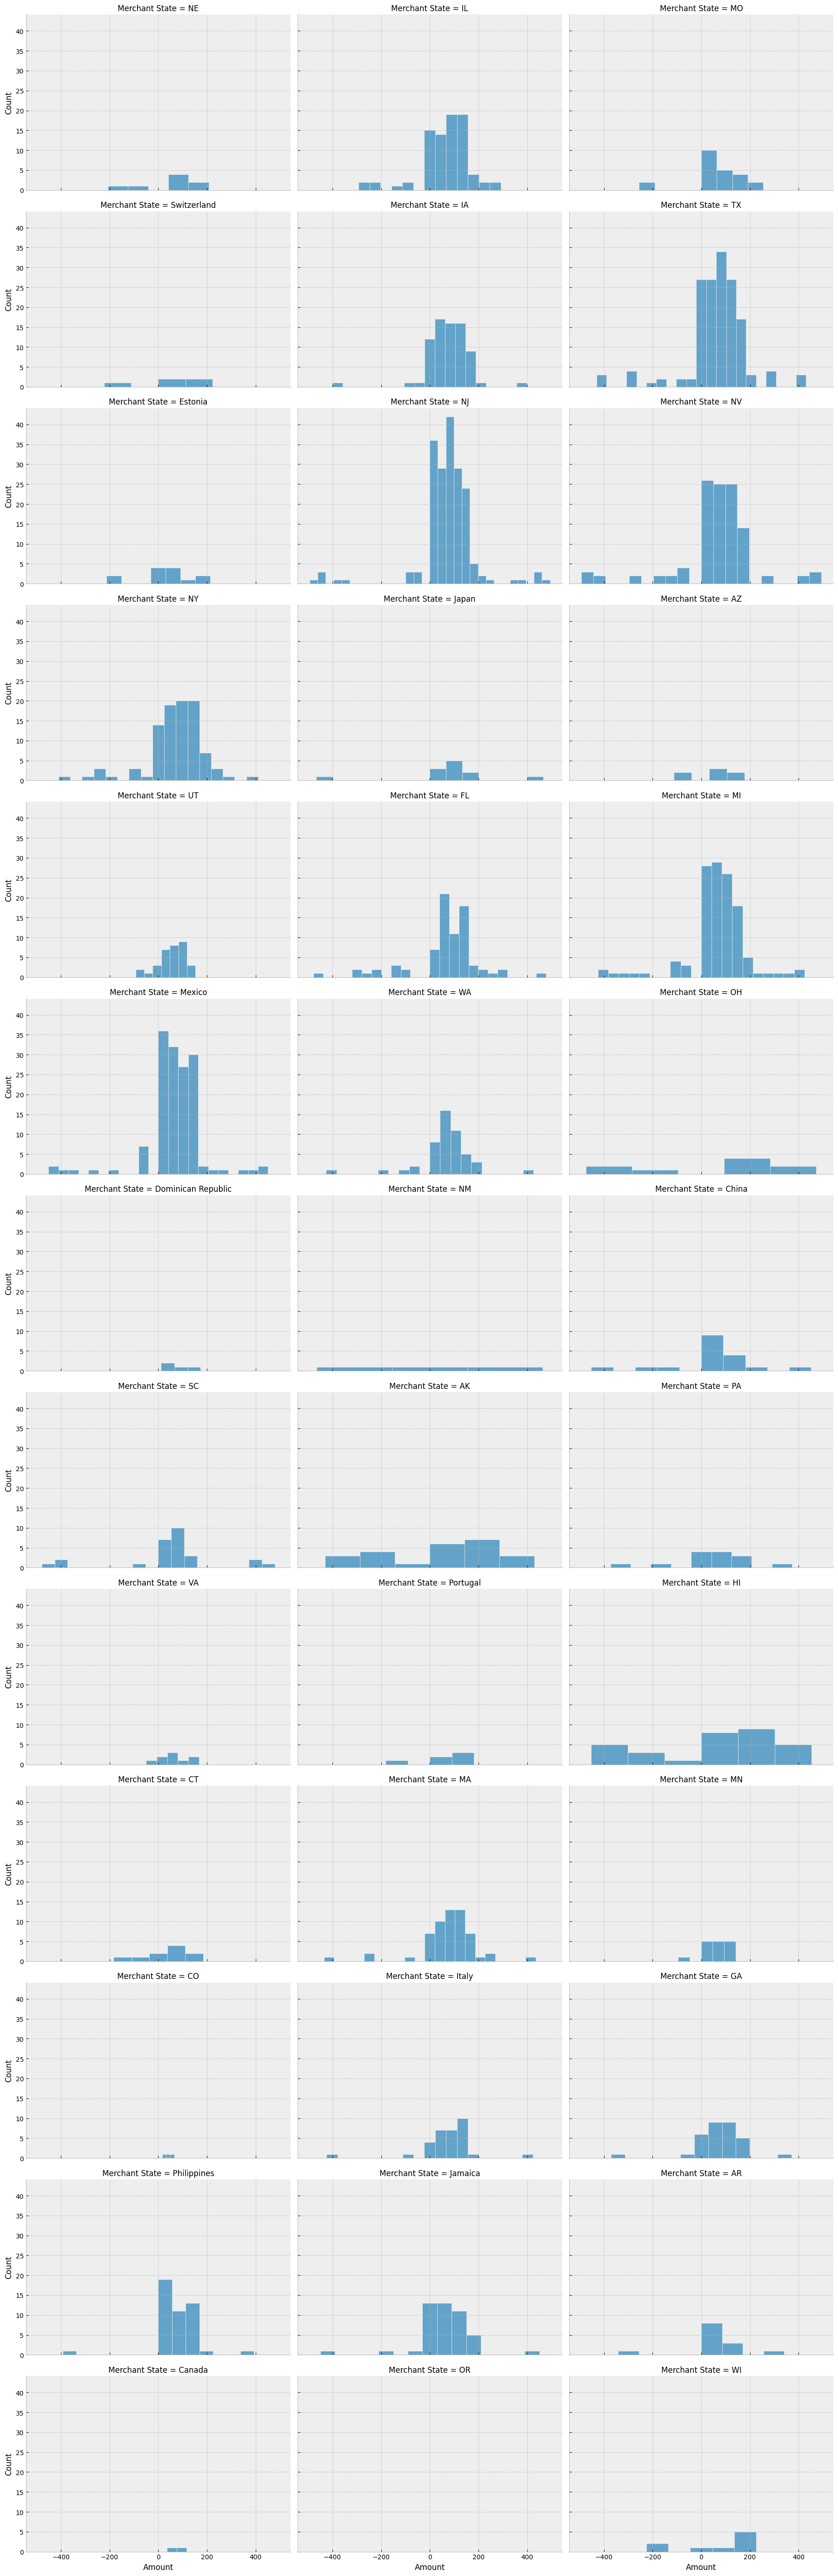

In [16]:
g = sns.FacetGrid(data_fraude.loc[data_fraude["Merchant State"] !="CA",:], col="Merchant State",height=4.27, aspect=11.7/8.27, col_wrap=3)
g.map(sns.histplot, "Amount")

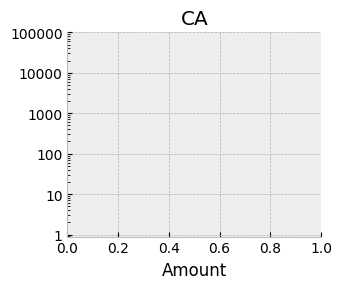

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a FacetGrid with one column for each state
g = sns.FacetGrid(data_fraude.loc[data_fraude["Merchant State"] == "CA",:], col="Merchant State", col_wrap=3)

# define the plotting function
def plot_histograms(data=None,**kwargs):
    sns.histplot(data=data_fraude.loc[(data_fraude["Merchant State"] == "CA") & (data_fraude["Fraud"] == "0"),:], x="Amount", alpha=0.5, bins=50, **kwargs)
    sns.histplot(data=data_fraude.loc[(data_fraude["Merchant State"] == "CA") & (data_fraude["Fraud"] == "1"),:], x="Amount", alpha=0.5, bins=50, color="red")

# use the plotting function with FacetGrid
g.map(plot_histograms, "Amount")

# add a title for each column
for ax, state in zip(g.axes.flat, data_fraude["Merchant State"].unique()):
    ax.set(title=state)
    ax.set_yscale("log")
    y_ticks = [1, 10, 100, 1000, 10000, 100000]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
# adjust the layout and save the plot
plt.tight_layout()
plt.show()

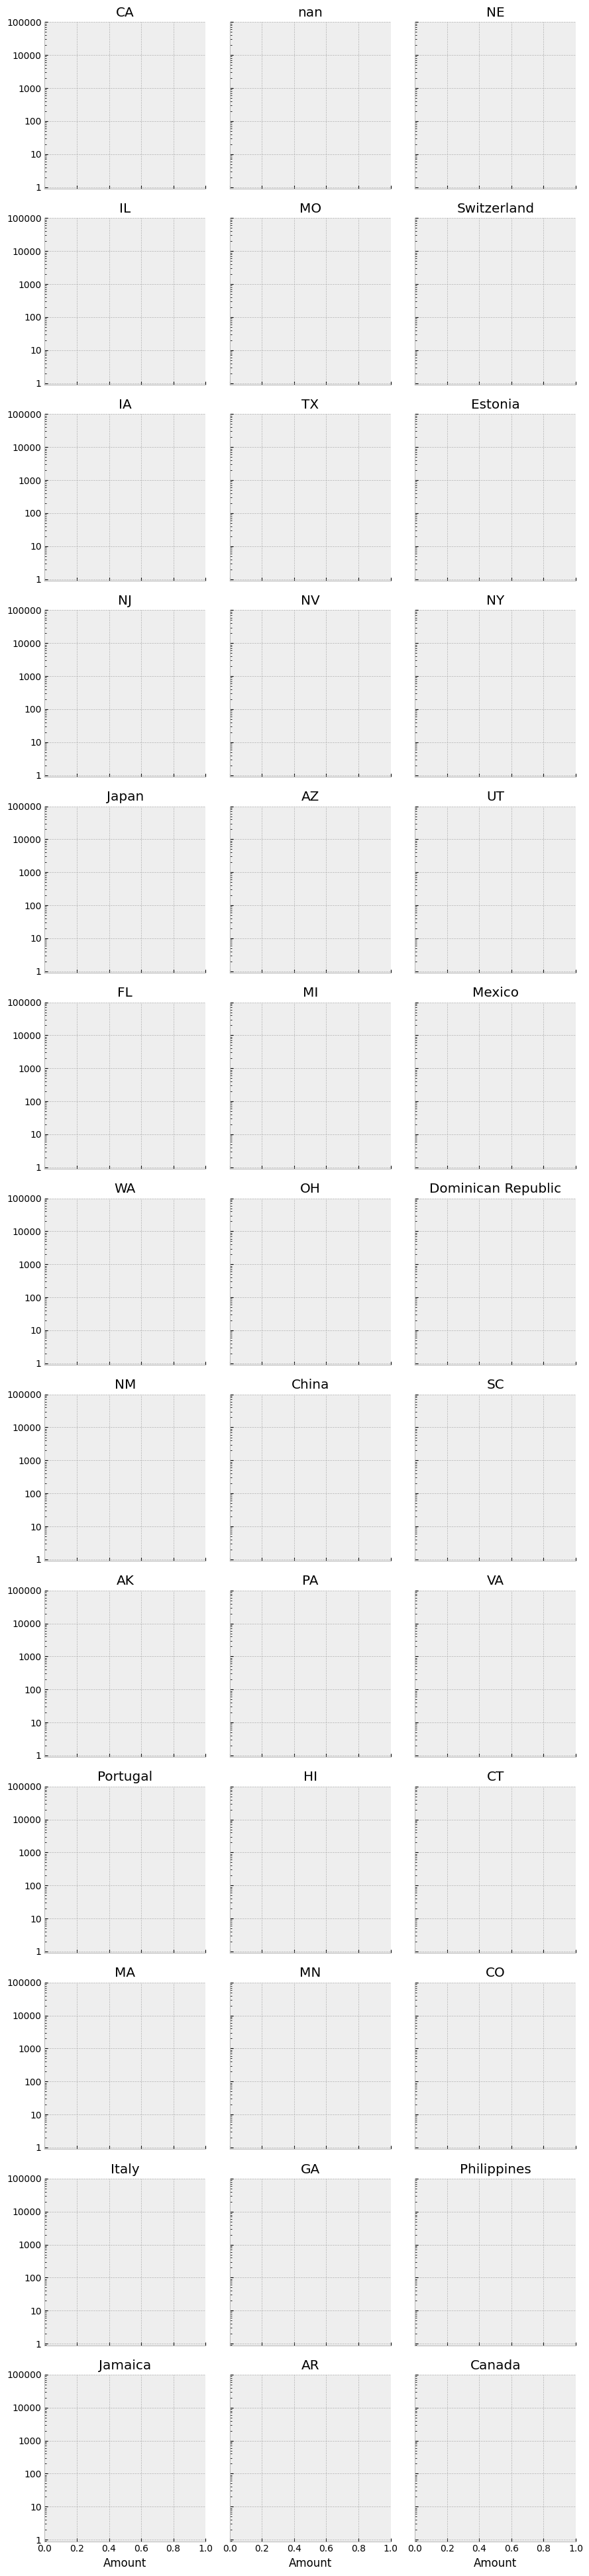

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a FacetGrid with one column for each state
g = sns.FacetGrid(data_fraude.loc[data_fraude["Merchant State"] != "CA",:], col="Merchant State", col_wrap=3)

# define the plotting function
def plot_histograms(data=None,**kwargs):
    sns.histplot(data=data_fraude.loc[(data_fraude["Merchant State"] != "CA") & (data_fraude["Fraud"] == "0"),:], x="Amount", alpha=0.5, bins=50, **kwargs)
    sns.histplot(data=data_fraude.loc[(data_fraude["Merchant State"] != "CA") & (data_fraude["Fraud"] == "1"),:], x="Amount", alpha=0.5, bins=50, color="red")

# use the plotting function with FacetGrid
g.map(plot_histograms, "Amount")

# add a title for each column
for ax, state in zip(g.axes.flat, data_fraude["Merchant State"].unique()):
    ax.set(title=state)
    ax.set_yscale("log")
    y_ticks = [1, 10, 100, 1000, 10000, 100000]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks)
# adjust the layout and save the plot
plt.tight_layout()
plt.show()


En esta gráfica donde cada faceta representa el histograma de los montos de fraude para cada estado vemos que la gran mayoría de las operaciones se realiza en California (CA). Esto da indicios que se requeriría examinar a más detalle esta variable ya que podría ameritar quedarse solamente con la data de California si es que las otras clases tienen muy pocos datos o considerar agrupar el resto de estados en una categoría Otros para que representen un clase de tamaño razonable tal que no fomentemos el sobreajuste de el modelo que desarrollemos. Realizando un análisis a mayor detenimiento separando los histogramas por fraude y no fraude e independizando California (aplicamos también escala logartímica al histograma para poder visualizar el histograma de fraude cuyos montos son mucho menores que los de no fraude) podemos ver que la distribución de fraude es similar en todos los estados y a una proporción similar vs el no fraude como en California lo cual nos llevaría a concluir que si vale la pena mantener el resto de estados en el análisis.

In [19]:
fraude_anual = data_fraude.loc[:,["Year","Amount"]].groupby("Year").sum()
x = fraude_anual.index
y = fraude_anual.Amount

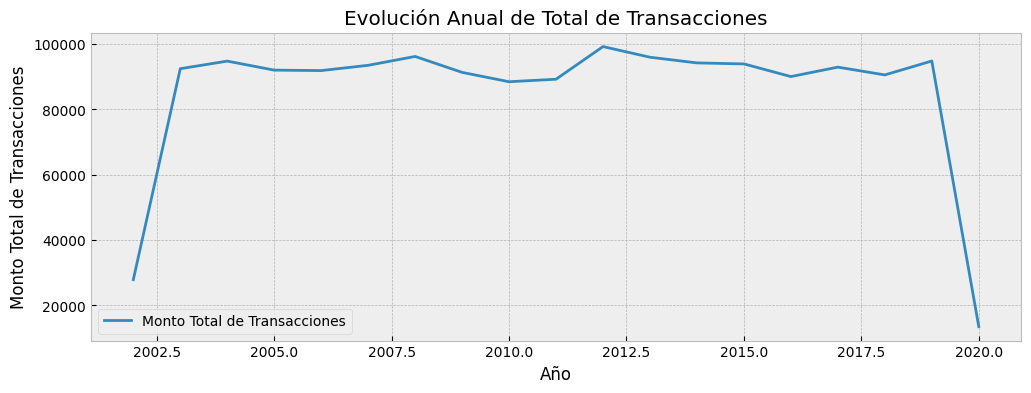

In [20]:
fig, ax = plt.subplots(figsize =(12, 4)) #"Is Fraud?"
ax.plot(x, y, label = "Monto Total de Transacciones")
ax.set_xlabel("Año")
ax.set_ylabel("Monto Total de Transacciones")
ax.set_title("Evolución Anual de Total de Transacciones")
ax.legend()

En este gráfico podemos ver la evolución del monto total de transacciones, dandonos cuenta que el monto es estable entre los años 2003 y 2019. Sin embargo el monto cae significativamente en el 2002 y 2020 esto podría indicar que la data en estas fechas son de periodos incompletos o tienen un comportamiento distinto por algún motivo que amerita investigar para determinar la fuente. Una posible solución si se identifica que hay información incompleta en estos dos años es eliminarlos de la muestra, en particular si se identifican patrones estacionales para los cuales ayude tener años con la misma representación de meses o días completos.

In [21]:
fraude_mensual = data_fraude.loc[:,["Month","Amount"]].groupby("Month").sum()
x = fraude_mensual.index
y = fraude_mensual.Amount

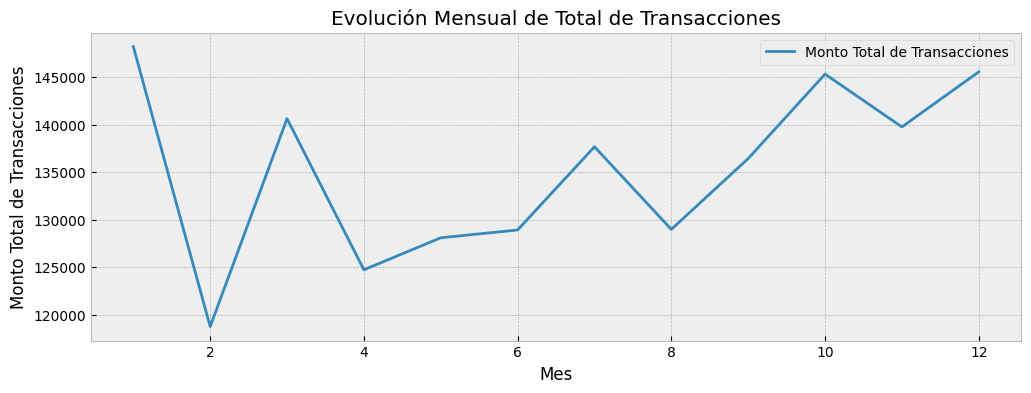

In [22]:
fig, ax = plt.subplots(figsize =(12, 4)) #"Is Fraud?"
ax.plot(x, y, label = "Monto Total de Transacciones")
ax.set_xlabel("Mes")
ax.set_ylabel("Monto Total de Transacciones")
ax.set_title("Evolución Mensual de Total de Transacciones")
ax.legend()

En está gráfica podemos ver que hay picos el monto de transacciones a inicios/fin de año, esto puede estar relacionado con el pico de consumo comercial por fiestas, esto podría servir para identificar una potencial estacionalidad en la data con pico en los meses 12-1 y nadir en medidados de año.

In [23]:
fraude_mensual = data_fraude.loc[:,["Month","Fraud","Amount"]].groupby(["Month","Fraud"]).sum().reset_index()
x0 = fraude_mensual.loc[fraude_mensual.loc[:,"Fraud"]==0 ,"Month"]
x1 = fraude_mensual.loc[fraude_mensual.loc[:,"Fraud"]==1 ,"Month"]
y0 = fraude_mensual.loc[fraude_mensual.loc[:,"Fraud"]==0 ,"Amount"]
y1 = fraude_mensual.loc[fraude_mensual.loc[:,"Fraud"]==1 ,"Amount"]

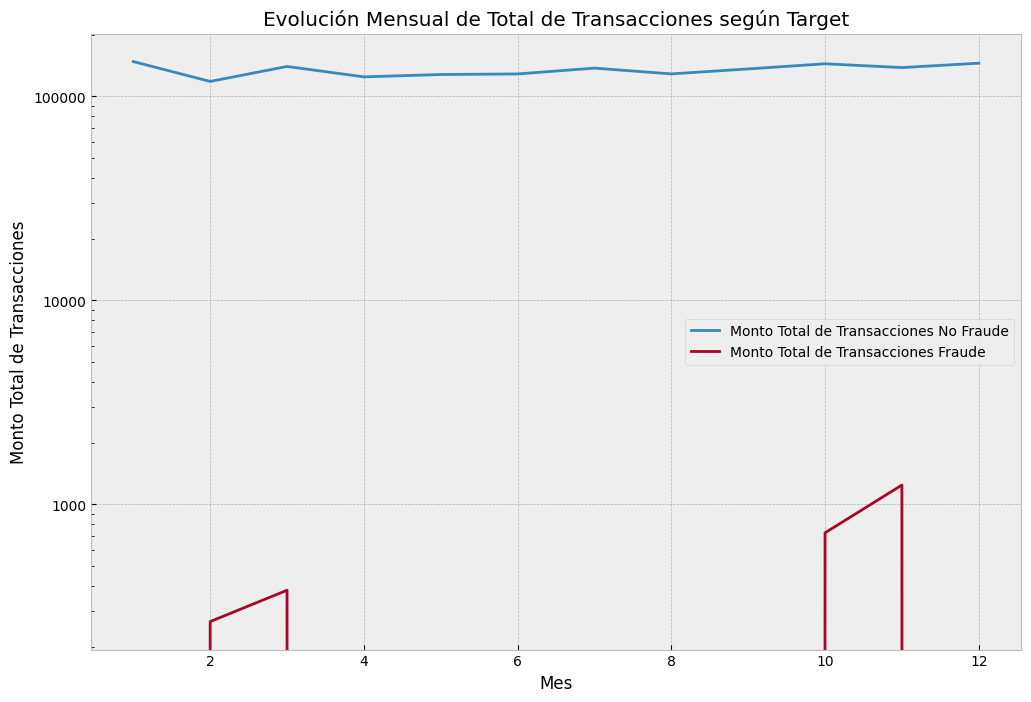

In [24]:
fig, ax = plt.subplots(figsize =(12, 8))
ax.plot(x0, y0, label = "Monto Total de Transacciones No Fraude")
ax.plot(x1, y1, label = "Monto Total de Transacciones Fraude")
ax.set_xlabel("Mes")
ax.set_ylabel("Monto Total de Transacciones")
ax.set_title("Evolución Mensual de Total de Transacciones según Target")
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.legend()

En esta gráfica podemos ver la evolución mensual de los montos de operación separados por los fraudes y no fraudes. Vemos que el fraude es un evento de rara ocurrencia ya que la incidencia de fraudes tiene 2 ordenes de magnitud menores que en el caso de no fraudes. Esto es importante tener en cuenta ya que la prevalencia de fraudes es pequeña en la data lo cual implicará que quizás se necesite aplicar alguna técnica de remuestreo o ponderación de clases para obtener un modelo que no solo aprenda de los casos no fraudulentos. También podemos ver que hubo fraude en 4 meses del año, se podría evaluar censurar la muestra para considerar los periodos de febrero a noviembre para incrementar un poco el porcentaje de fraudes de la muestra.

## Feature Engineering y limpieza de datos

In [25]:
data_fraude.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Fraud'],
      dtype='object')

In [26]:
data_fraude.dtypes

User                 int64
Card                 int64
Year                 int64
Month                int64
Day                  int64
Time                object
Amount             float64
Use Chip            object
Merchant Name        int64
Merchant City       object
Merchant State      object
Zip                float64
MCC                  int64
Errors?             object
Fraud             category
dtype: object

In [27]:
data_fraude["Errors?"].unique()

array([nan, 'Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad PIN,Insufficient Balance', 'Bad Expiration',
       'Bad PIN,Technical Glitch', 'Bad Card Number', 'Bad CVV'],
      dtype=object)

In [28]:
# fill NaN values in the Errors? column with mode
data_fraude['Errors?'].fillna("Other", inplace=True)


# convert 'Errors?' column to integer encoding
data_fraude['Errors?'] = pd.factorize(data_fraude['Errors?'])[0]


# check if there are any remaining NaN values in the dataset
#print(data_fraude.isnull().sum())

In [29]:
# Check for missing values
print(data_fraude.isna().sum())

User                 0
Card                 0
Year                 0
Month                0
Day                  0
Time                 0
Amount               0
Use Chip             0
Merchant Name        0
Merchant City        0
Merchant State    1317
Zip               1647
MCC                  0
Errors?              0
Fraud                0
dtype: int64


In [30]:
# Check if missing values are correlated with other variables and filter to only show rows with non-zero sum
missing_values = data_fraude.groupby(['Merchant City', 'Year', 'Month'])[['Merchant State', 'Zip']].apply(lambda x: x.isna().sum())
missing_values_Zip = missing_values[(missing_values['Merchant State'] > 0)]
missing_values_MS = missing_values[ (missing_values['Zip'] > 0)]
missing_values_both = missing_values[(missing_values['Merchant State'] > 0) & (missing_values['Zip'] > 0)]

In [31]:
print(missing_values_Zip)

                          Merchant State  Zip
Merchant City Year Month                     
ONLINE        2002 9                   3    3
                   10                  2    2
                   11                  1    1
                   12                  6    6
              2003 1                   6    6
...                                  ...  ...
              2019 10                  6    6
                   11                  6    6
                   12                  3    3
              2020 1                  10   10
                   2                   8    8

[209 rows x 2 columns]


In [32]:
print(missing_values_MS)

                           Merchant State  Zip
Merchant City  Year Month                     
Beijing        2009 3                   0    3
                    4                   0    8
Cabo San Lucas 2006 6                   0   34
Cancun         2008 1                   0   14
               2012 12                  0    9
...                                   ...  ...
Shanghai       2017 2                   0    7
Tallinn        2004 7                   0   13
Tokyo          2005 2                   0   12
Toronto        2019 3                   0    2
Zurich         2003 2                   0    5

[230 rows x 2 columns]


In [33]:
print(missing_values_both)

                          Merchant State  Zip
Merchant City Year Month                     
ONLINE        2002 9                   3    3
                   10                  2    2
                   11                  1    1
                   12                  6    6
              2003 1                   6    6
...                                  ...  ...
              2019 10                  6    6
                   11                  6    6
                   12                  3    3
              2020 1                  10   10
                   2                   8    8

[209 rows x 2 columns]


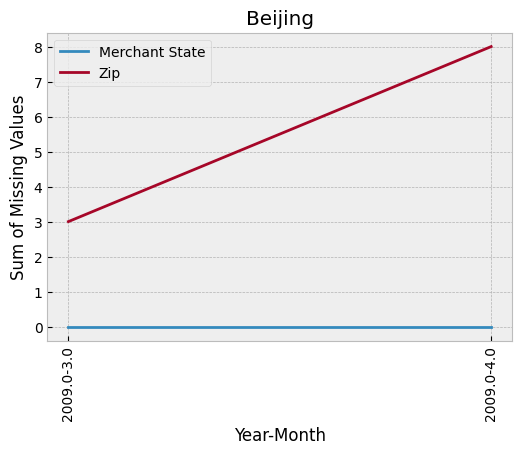

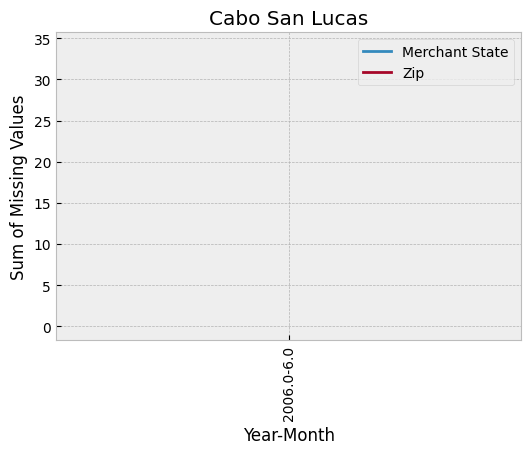

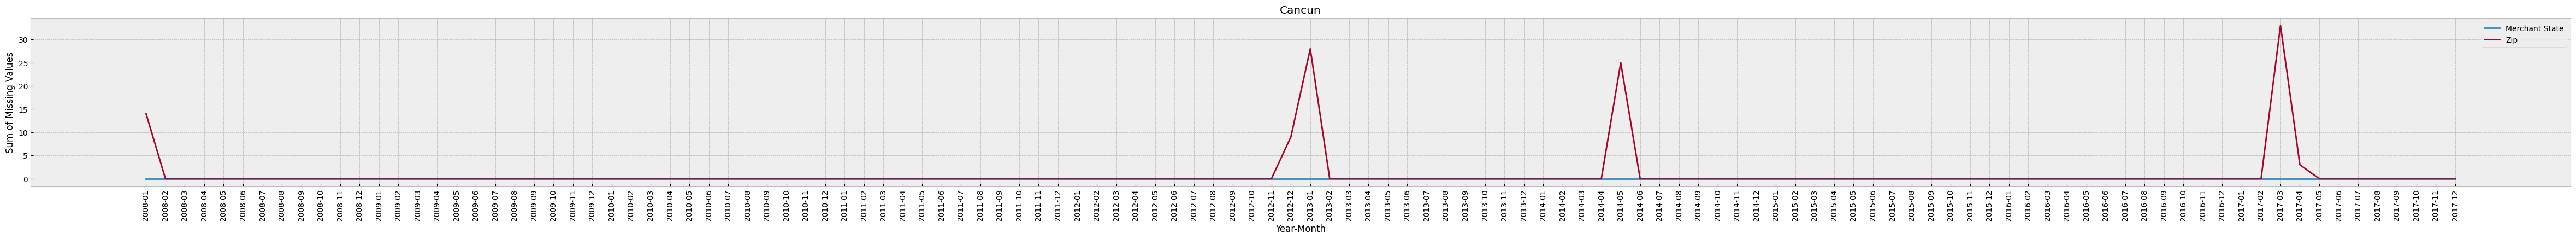

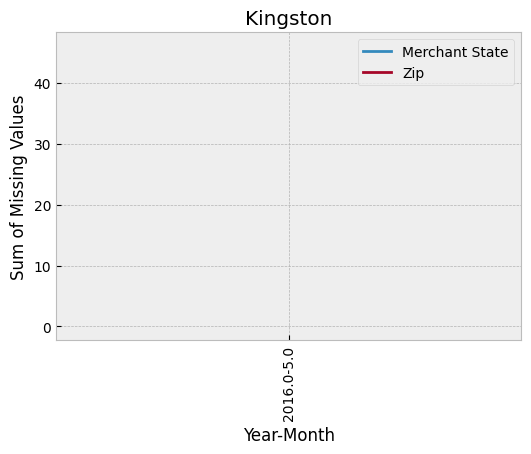

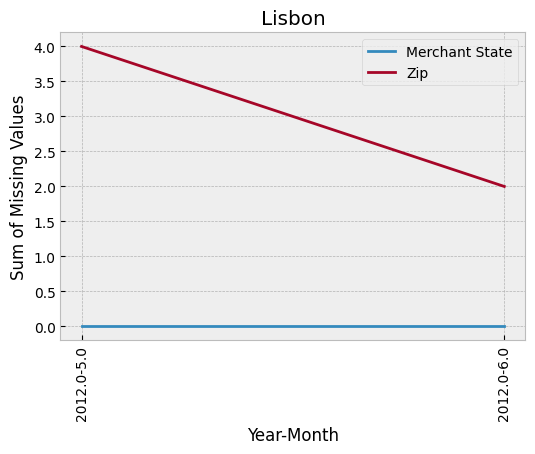

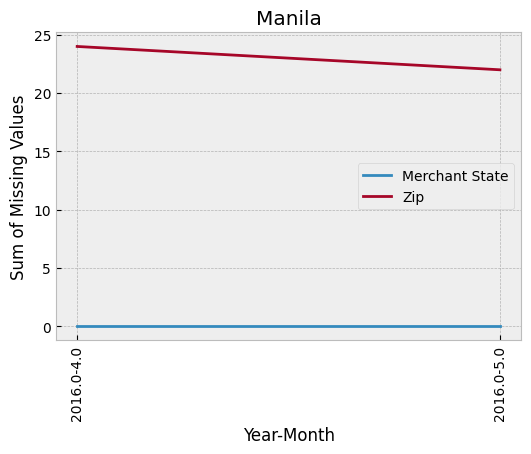

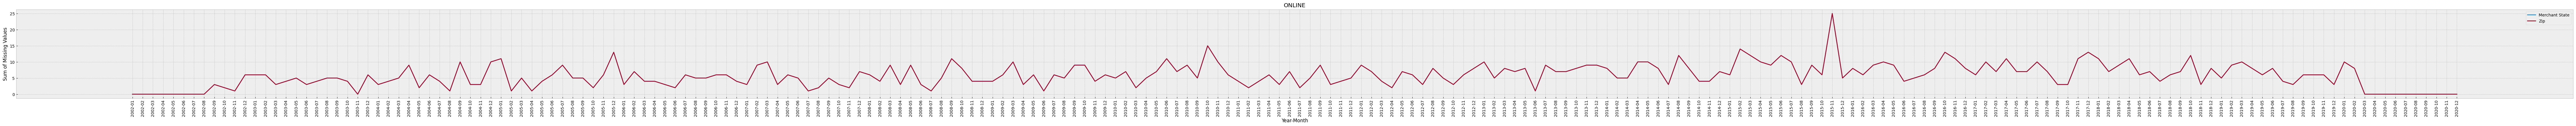

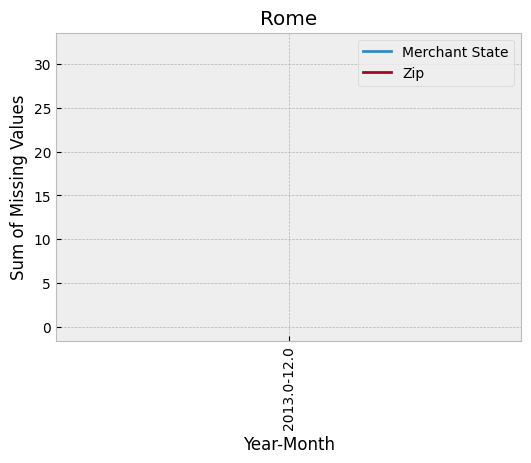

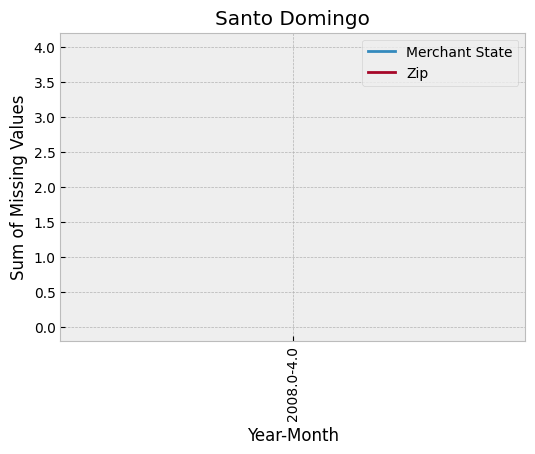

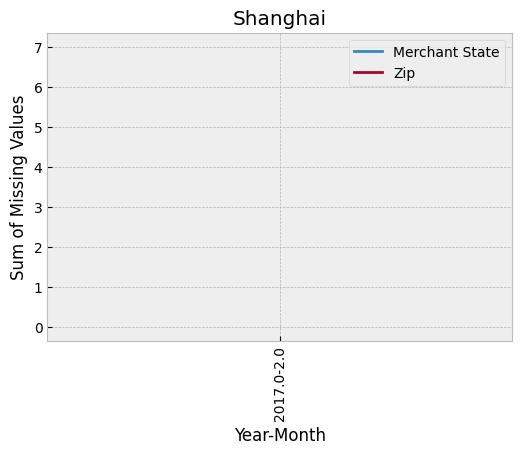

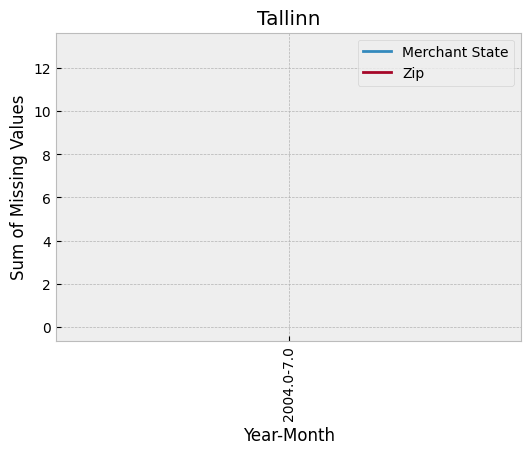

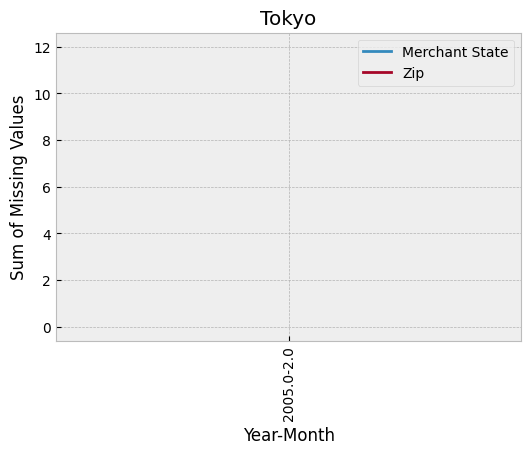

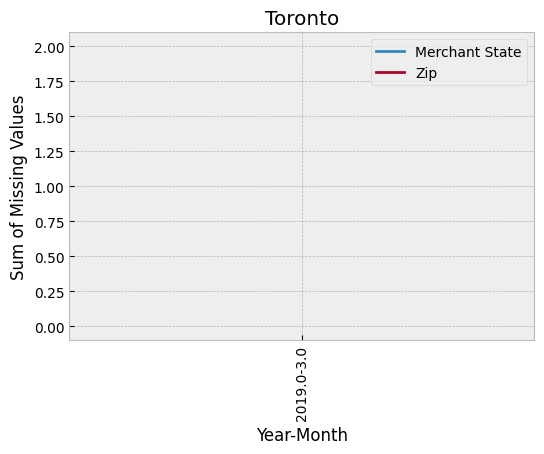

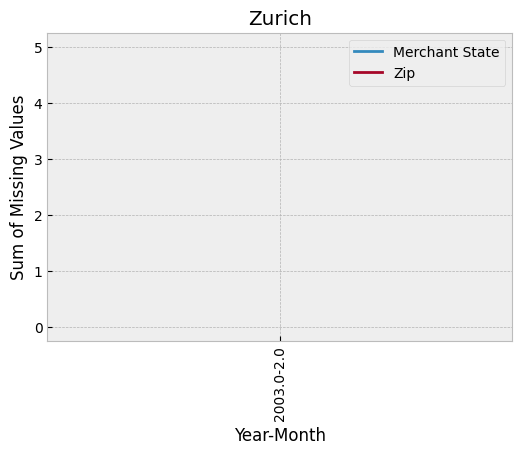

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate sum of missing values by year and month for each Merchant City
missing_values = data_fraude.groupby(['Merchant City', 'Year', 'Month'])[['Merchant State', 'Zip']].apply(lambda x: x.isna().sum())
missing_values.reset_index(inplace=True)
missing_cities = []
# Define function to add missing rows with sum 0 for each year-month combination within a city
def add_missing_rows(df, min_year_month, max_year_month):
    city = df['Merchant City'].iloc[0]
    all_year_months = pd.date_range(min_year_month, max_year_month, freq='MS').strftime('%Y-%m')
    existing_year_months = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)
    missing_year_months = list(set(all_year_months) - set(existing_year_months))
    missing_rows = pd.DataFrame({'Merchant City': [city] * len(missing_year_months),
                                 'Year': [int(ym.split('-')[0]) for ym in missing_year_months],
                                 'Month': [int(ym.split('-')[1]) for ym in missing_year_months],
                                 'Merchant State': [0] * len(missing_year_months),
                                 'Zip': [0] * len(missing_year_months)})
    return pd.concat([df, missing_rows]).sort_values(['Year', 'Month']).reset_index(drop=True)

# Create line graph for each Merchant City with missing values by year and month
for city, city_df in missing_values.groupby('Merchant City'):
    # Check if there are any missing values for the city
    if city_df[['Merchant State', 'Zip']].sum().sum() > 0:
        # Add missing rows with sum 0 for each year-month combination within the city
        min_year_month = city_df[['Year', 'Month']].min().apply(str).str.cat(sep='-')
        max_year_month = city_df[['Year', 'Month']].max().apply(str).str.cat(sep='-')
        city_df = add_missing_rows(city_df, min_year_month, max_year_month)
        missing_cities.append(city)
        # Create line plot of missing values by year and month
        fig, ax = plt.subplots(figsize=(max(len(city_df)/2, 6), 4))
        ax.plot(city_df['Year'].astype(str) + '-' + city_df['Month'].astype(str).str.zfill(2), city_df['Merchant State'], label='Merchant State')
        ax.plot(city_df['Year'].astype(str) + '-' + city_df['Month'].astype(str).str.zfill(2), city_df['Zip'], label='Zip')
        for tick in ax.get_xticklabels():
          tick.set_rotation(90)
        ax.set_title(city)
        ax.set_xlabel('Year-Month')
        ax.set_ylabel('Sum of Missing Values')
        ax.legend()
        plt.show()

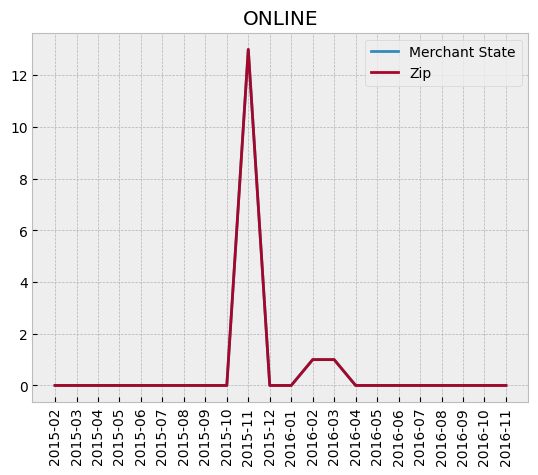

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate sum of missing values by year and month for each Merchant City
missing_values = data_fraude[data_fraude["Fraud"]==1].groupby(['Merchant City', 'Year', 'Month'])[['Merchant State', 'Zip']].apply(lambda x: x.isna().sum())
missing_values.reset_index(inplace=True)

# Define function to add missing rows with sum 0 for each year-month combination within a city
def add_missing_rows(df, min_year_month, max_year_month):
    city = df['Merchant City'].iloc[0]
    all_year_months = pd.date_range(min_year_month, max_year_month, freq='MS').strftime('%Y-%m')
    existing_year_months = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)
    missing_year_months = list(set(all_year_months) - set(existing_year_months))
    missing_rows = pd.DataFrame({'Merchant City': [city] * len(missing_year_months),
                                 'Year': [int(ym.split('-')[0]) for ym in missing_year_months],
                                 'Month': [int(ym.split('-')[1]) for ym in missing_year_months],
                                 'Merchant State': [0] * len(missing_year_months),
                                 'Zip': [0] * len(missing_year_months)})
    return pd.concat([df, missing_rows]).sort_values(['Year', 'Month']).reset_index(drop=True)

# Create line graph for each Merchant City with missing values by year and month
for city, city_df in missing_values.groupby('Merchant City'):
    # Check if there are any missing values for the city
    if city_df[['Merchant State', 'Zip']].sum().sum() > 0:
        # Add missing rows with sum 0 for each year-month combination within the city
        min_year_month = city_df[['Year', 'Month']].min().apply(str).str.cat(sep='-')
        max_year_month = city_df[['Year', 'Month']].max().apply(str).str.cat(sep='-')
        city_df = add_missing_rows(city_df, min_year_month, max_year_month)

        # Create line plot of missing values by year and month
        plt.figure()
        plt.plot(city_df['Year'].astype(str) + '-' + city_df['Month'].astype(str).str.zfill(2), city_df['Merchant State'], label='Merchant State')
        plt.plot(city_df['Year'].astype(str) + '-' + city_df['Month'].astype(str).str.zfill(2), city_df['Zip'], label='Zip')
        plt.xticks(rotation=90)
        plt.title(city)
        plt.legend()
        plt.show()

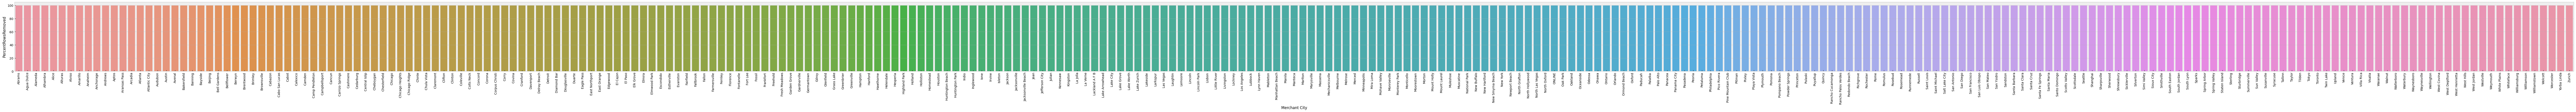

In [36]:
# Find users related to missing values
missing_users = data_fraude.loc[data_fraude['Merchant State'].isna() | data_fraude['Zip'].isna(), 'User'].unique()

# Group by Merchant City and count rows containing missing users
missing_rows = data_fraude.loc[data_fraude['User'].isin(missing_users)]\
    .groupby('Merchant City')\
    .size()\
    .rename('NumRowsWithMissingUsers')\
    .reset_index()

# Group by Merchant City and count total rows
total_rows = data_fraude.groupby('Merchant City')\
    .size()\
    .rename('TotalNumRows')\
    .reset_index()

# Merge missing_rows and total_rows
df = pd.merge(missing_rows, total_rows, on='Merchant City')

# Calculate the percentage of rows that would be removed
df['PercentRowsRemoved'] = df['NumRowsWithMissingUsers'] / df['TotalNumRows'] * 100

# Filter out empty graphs
df = df.loc[df['TotalNumRows'] != 0]

# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(max(len(df)/2, 6), 4))
sns.barplot(x='Merchant City', y='PercentRowsRemoved', data=df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [37]:
# Custom function to impute missing values if user has more than 30 data points in same year-month
def impute_user_year_month(x):
    if x['Zip'].isnull().all():
        x['Zip'] = x['Zip'].fillna(x['Zip'].groupby([x['Year'], x['Month']]).transform(lambda y: y.mean()) if len(x[x['Year'] == x['Year'].max()][x['Month'] == x[x['Year'] == x['Year'].max()]['Month'].max()]) > 30 else x['Zip'].groupby(x['Year']).transform(lambda y: y.mean()) if len(x[x['Year'] == x['Year'].max()]) > 30 else x['Zip'].transform(lambda y: y.mean()))
    if x['Merchant State'].isnull().all():
        x['Merchant State'] = x['Merchant State'].fillna(x['Merchant State'].groupby([x['Year'], x['Month']]).transform(lambda y: y.mode()[0]) if len(x[x['Year'] == x['Year'].max()][x['Month'] == x[x['Year'] == x['Year'].max()]['Month'].max()]) > 30 else x['Merchant State'].groupby(x['Year']).transform(lambda y: y.mode()[0]) if len(x[x['Year'] == x['Year'].max()]) > 30 else x['Merchant State'].mode()[0])
    return x

# Group by User and apply custom function to impute missing values if user has more than 30 data points in same year-month
data_fraude = data_fraude.groupby('User').apply(impute_user_year_month)

<ipython-input-37-4b93da7c77dc>:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_fraude = data_fraude.groupby('User').apply(impute_user_year_month)


In [38]:
# Impute missing values in Zip and Merchant State columns
data_fraude['Zip'] = data_fraude.groupby('Merchant City')['Zip'].apply(lambda x: x.fillna(x.mean()))
data_fraude['Merchant State'] = data_fraude.groupby('Merchant City')['Merchant State'].apply(lambda x: x.fillna(x.mode()))

<ipython-input-38-f341a70913a8>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_fraude['Zip'] = data_fraude.groupby('Merchant City')['Zip'].apply(lambda x: x.fillna(x.mean()))
<ipython-input-38-f341a70913a8>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data_fraude['Merchant State'] = d

In [39]:
import requests

def get_ip():
    return requests.get('https://api.ipify.org').text

print('IP address of Google Colab:', get_ip())

IP address of Google Colab: 104.199.120.71


In [40]:
# Obtain the missing values for Zip using the geolocation information of city and state
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderQuotaExceeded

# Define a function to get Zip code from geolocation
def get_zip(city, state):
    geolocator = Nominatim(user_agent="project", timeout=10)
    location = None
    while location is None:
        if city == "ONLINE":
          return None
        try:
            location = geolocator.geocode(city + ", " + state)
            time.sleep(2)  # Ensures at least 1 second between requests
        except GeocoderTimedOut:
            continue
        except GeocoderQuotaExceeded:
            print("GeocoderQuotaExceeded: The usage limit has been exceeded. Try again later.")
            break
    if location is not None and 'address' in location.raw:
        return location.raw['address'].get('postcode')
    elif location is not None:
      return location.raw['place_id']
    else:
        return None


# Find all missing Zip codes for non-ONLINE merchant cities
missing_zips = data_fraude.loc[(data_fraude['Zip'].isna()) & (data_fraude['Use Chip'] != 'ONLINE'), ['Merchant City', 'Merchant State']].drop_duplicates()

# Iterate over missing_zips and get Zip code for each city and state combination
for index, row in missing_zips.iterrows():
    city = row['Merchant City']
    state = row['Merchant State']
    zip_code = get_zip(city, state)
    if zip_code is not None:
        data_fraude.loc[(data_fraude['Zip'].isna()) & (data_fraude['Merchant City'] == city) & (data_fraude['Merchant State'] == state), 'Zip'] = zip_code


In [41]:
# Create a datetime column base on av. time related variables
data_fraude['datetime'] = pd.to_datetime(data_fraude['Year'].astype(str) + '-' + data_fraude['Month'].astype(str) + '-' + data_fraude['Day'].astype(str) + ' ' + data_fraude['Time'])

In [42]:
data_fraude.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Fraud,datetime
0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,0,0,2002-09-01 06:21:00
1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,0,2002-09-01 06:42:00
2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,0,0,2002-09-02 06:22:00
3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,0,0,2002-09-02 17:45:00
4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,0,0,2002-09-03 06:23:00


In [43]:
# Sort data by User and datetime
data_fraude = data_fraude.sort_values(['User', 'datetime'])

# Create Recency feature
data_fraude['Last Transaction Hours'] = (data_fraude.groupby('User')['datetime'].diff() / pd.Timedelta(hours=1)).fillna(0)
data_fraude['Last Transaction Days'] = (data_fraude.groupby('User')['datetime'].diff() / pd.Timedelta(days=1)).fillna(0)

# Create Frequency feature
data_fraude['Transactions Past Week'] = data_fraude.groupby('User')['datetime'].rolling(7, min_periods=1).count().values
data_fraude['Transactions Past Month'] = data_fraude.groupby('User')['datetime'].rolling(30, min_periods=1).count().values
data_fraude['Transactions Past Year'] = data_fraude.groupby('User')['datetime'].rolling(365, min_periods=1).count().values

# Create Previous Amount feature
data_fraude['Previous Amount'] = data_fraude.groupby('User')['Amount'].shift(fill_value=0)

# Create Recency feature by Country
data_fraude['Last Transaction Days by Country'] = data_fraude.groupby(['User', 'Merchant State'])['datetime'].diff() / pd.Timedelta(1,"d")
# Create Recency feature by City
data_fraude['Last Transaction Days by City'] = data_fraude.groupby(['User', 'Merchant City'])['datetime'].diff() / pd.Timedelta(1,"d")
# Create Recency feature by Merchant
data_fraude['Last Transaction Days by Merchant'] = data_fraude.groupby(['User', 'Merchant Name'])['datetime'].diff() / pd.Timedelta(1,"d")

# Create Frequency feature by Country
data_fraude['Transactions Past Week by Country'] = data_fraude.groupby(['User', 'Merchant State'])['datetime'].rolling(7, min_periods=1).count().reset_index().set_index('level_2')['datetime']
data_fraude['Transactions Past Month by Country'] = data_fraude.groupby(['User', 'Merchant State'])['datetime'].rolling(30, min_periods=1).count().reset_index().set_index('level_2')['datetime']
data_fraude['Transactions Past Year by Country'] = data_fraude.groupby(['User', 'Merchant State'])['datetime'].rolling(365, min_periods=1).count().reset_index().set_index('level_2')['datetime']
# Create Frequency feature by City
data_fraude['Transactions Past Week by City'] = data_fraude.groupby(['User', 'Merchant City'])['datetime'].rolling(7, min_periods=1).count().reset_index().set_index('level_2')['datetime']
data_fraude['Transactions Past Month by City'] = data_fraude.groupby(['User', 'Merchant City'])['datetime'].rolling(30, min_periods=1).count().reset_index().set_index('level_2')['datetime']
data_fraude['Transactions Past Year by City'] = data_fraude.groupby(['User', 'Merchant City'])['datetime'].rolling(365, min_periods=1).count().reset_index().set_index('level_2')['datetime']
# Create Frequency feature by Merchant
data_fraude['Transactions Past Week by Merchant'] = data_fraude.groupby(['User', 'Merchant Name'])['datetime'].rolling(7, min_periods=1).count().reset_index().set_index('level_2')['datetime']
data_fraude['Transactions Past Month by Merchant'] = data_fraude.groupby(['User', 'Merchant Name'])['datetime'].rolling(30, min_periods=1).count().reset_index().set_index('level_2')['datetime']
data_fraude['Transactions Past Year by Merchant'] = data_fraude.groupby(['User', 'Merchant Name'])['datetime'].rolling(365, min_periods=1).count().reset_index().set_index('level_2')['datetime']

In [ ]:
geolocator = Nominatim(user_agent="my_project", timeout=10)

# Create a dictionary to store the latitudes and longitudes of cities
# where the key is a tuple of (Merchant City, Merchant State)
city_dict = {}
city_dict[('Lackland A F B', 'TX')] = (29.3387, -98.5987)
# Define a function to geocode the cities and states/countries
def geocode_city(row):
    city_state = (row['Merchant City'], row['Merchant State'])
    if row['Merchant City'] == "ONLINE":
        row['Latitude'] = None
        row['Longitude'] = None
        return row

    # Check if the latitude and longitude already exists in the dictionary
    if city_state in city_dict:
        row['Latitude'] = city_dict[city_state][0]
        row['Longitude'] = city_dict[city_state][1]
    else:
        # If not, get the location from geolocator and add it to the dictionary
        #print(city_state)
        location = geolocator.geocode(row['Merchant City'] + ', ' + row['Merchant State'], exactly_one=True)
        if location:
            row['Latitude'] = location.latitude
            row['Longitude'] = location.longitude
            city_dict[city_state] = (location.latitude, location.longitude)
        else:
            row['Latitude'] = None
            row['Longitude'] = None
            city_dict[city_state] = (None, None)
    return row

# Apply the function to the dataset
data_fraude = data_fraude.apply(geocode_city, axis=1)

In [ ]:
# Create previous city and previous state features
data_fraude['Previous City'] = data_fraude.groupby('User')['Merchant City'].shift(fill_value='')
data_fraude['Previous State'] = data_fraude.groupby('User')['Merchant State'].shift(fill_value='')

# Create previous geolocation
data_fraude['Previous Latitude'] = data_fraude.groupby('User')['Latitude'].shift(fill_value='')
data_fraude['Previous Longitude'] = data_fraude.groupby('User')['Longitude'].shift(fill_value='')

# Create previous city and previous state features correcting for ONLINE
data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE', 'Previous City'] = data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE'].groupby('User')['Merchant City'].shift(fill_value='')
data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE', 'Previous State'] = data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE'].shift(fill_value='')

# Create previous geolocation correcting for ONLINE
data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE', 'Previous Latitude'] = data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE'].groupby('User')['Latitude'].shift(fill_value='')
data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE', 'Previous Longitude'] = data_fraude.loc[data_fraude['Merchant City'] != 'ONLINE'].groupby('User')['Longitude'].shift(fill_value='')


from geopy.distance import geodesic

def flight_time(curr_lat, curr_lon, prev_lat, prev_lon,city=None,state=None,prev_city=None,prev_state=None):
    #print(city,state,prev_city,prev_state)
    if city == "ONLINE" or prev_city=="ONLINE":
      return 0
    distance = geodesic((curr_lat, curr_lon), (prev_lat, prev_lon)).km
    airspeed = 1200 # km/h
    return distance / airspeed

data_fraude['Flight Time'] = data_fraude.apply(lambda x: flight_time(x['Latitude'], x['Longitude'], x['Previous Latitude'], x['Previous Longitude'],x['Merchant City'],x['Merchant State'],x['Previous City'],x['Previous State']), axis=1)

In [ ]:
data_fraude.loc[(data_fraude["Previous City"].isna()) |(data_fraude["Merchant City"] == "ONLINE") | ((data_fraude["Merchant City"] == data_fraude['Previous City']) & (data_fraude["Merchant State"] == data_fraude['Previous State'])),'Flight Time'] = 0

# The amount of time that the person has to make the transaction given highly optimistic travel times between locations
data_fraude['Transaction Interval Budget'] = data_fraude['Last Transaction Hours'] - data_fraude['Flight Time']


In [ ]:
# Save data with new features to CSV file
data_fraude.to_csv('data_fraude_aug.csv', index=False)

# Read data from CSV file
data_fraude = pd.read_csv('data_fraude_aug.csv', dtype={'Fraud': 'category'})

In [ ]:
data_fraude.dtypes

In [ ]:
data_fraude.head()

In [ ]:
data_fraude['datetime'] = pd.to_datetime(data_fraude['datetime'])
data_fraude['Hour'] = data_fraude['datetime'].dt.hour
data_fraude['Minute'] = data_fraude['datetime'].dt.minute
data_fraude['Second'] = data_fraude['datetime'].dt.second
data_fraude['Day of Week'] = data_fraude['datetime'].dt.dayofweek

# Define office hours as weekdays from 9am to 5pm
office_hours = ((data_fraude['Hour'] >= 9) & (data_fraude['Hour'] < 17) & (data_fraude['Day of Week'] < 5)).astype(int)
data_fraude['UsualOfficeHours'] = office_hours

# Define sleeping hours as midnight to 6am
sleeping_hours = ((data_fraude['Hour'] >= 0) & (data_fraude['Hour'] < 6)).astype(int)
data_fraude['UsualSleepingHours'] = sleeping_hours

# Define lunch hours as weekdays from noon to 1pm
lunch_hours = ((data_fraude['Hour'] >= 12) & (data_fraude['Hour'] < 13) & (data_fraude['Day of Week'] < 5)).astype(int)
data_fraude['UsualLunchHours'] = lunch_hours

# Define commute to work hours as weekdays from 7am to 9am and 5pm to 7pm
commute_hours = ((data_fraude['Hour'] >= 7) & (data_fraude['Hour'] < 9)) & (data_fraude['Day of Week'] < 5)
commute_hours = commute_hours.astype(int)
data_fraude['UsualCommuteToWorkHours'] = commute_hours
commute_hours = ((data_fraude['Hour'] >= 17) & (data_fraude['Hour'] < 19)) & (data_fraude['Day of Week'] < 5)
commute_hours = commute_hours.astype(int)
data_fraude['UsualCommuteFromWorkHours'] = commute_hours

In [ ]:
data_fraude.columns

# Feature Selection

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# Select the relevant columns
X = data_fraude[['Year', 'Month', 'Day',"Hour","Minute","Second","Day of Week",
                 'UsualOfficeHours','UsualSleepingHours','UsualLunchHours','UsualCommuteToWorkHours',
                 'UsualCommuteFromWorkHours','Amount', 'Use Chip',
                 'Merchant City', 'Merchant State', 'MCC', 'Previous City',
                 'Previous State', 'Latitude', 'Longitude', 'Transaction Interval Budget',
                 'Last Transaction Days',
                 'Transactions Past Week', 'Transactions Past Month',
                 'Transactions Past Year', 'Previous Amount',
                 'Last Transaction Days by Country', 'Last Transaction Days by City',
                 'Last Transaction Days by Merchant',
                 'Transactions Past Week by Country',
                 'Transactions Past Month by Country',
                 'Transactions Past Year by Country', 'Transactions Past Week by City',
                 'Transactions Past Month by City', 'Transactions Past Year by City',
                 'Transactions Past Week by Merchant',
                 'Transactions Past Month by Merchant',
                 'Transactions Past Year by Merchant','Last Transaction Hours',
                 'Previous Latitude', 'Previous Longitude',
                 'Flight Time']]
y = data_fraude['Fraud']

# Encode categorical variables using one-hot encoding
cat_columns = ['Use Chip', 'Merchant City', 'Merchant State', 'Previous City', 'Previous State','MCC']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X[cat_columns])
X_cat = enc.transform(X[cat_columns]).toarray()

# Combine the encoded categorical variables with the numerical variables
X_num = X.drop(cat_columns, axis=1)
X_encoded = np.concatenate((X_num, X_cat), axis=1)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Impute the missing values in X_scaled
X_imputed = imputer.fit_transform(X_scaled)

# Apply PCA to select the top 5 most important features
pca = PCA(n_components=400)
X_pca = pca.fit_transform(X_imputed)

# Show the variable importance
import matplotlib.pyplot as plt
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('Variance explained')
plt.show()

In [ ]:
pca = PCA()
pca.fit(X_imputed)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance vs number of components
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

La curva de PCA crece con una tasa de aumento que disminuye linealmente lo cual indica que no hay un punto de codo que abarque la mayor parte de la explicabilidad del modelo o que permita distinguir a simple vista un punto de inflexión en la varianza explicada acumulada por lo que PCA no es un método apropiado para esta problemática por lo que optaremos por otra técnica de selección de variables utilizando la importancia de variables que deriva de un modelo de random forest a continuación:

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Instantiate the base model
rf = RandomForestClassifier(random_state=42)
# Create a range of feature selection thresholds to try
thresholds = np.arange(0.0005, 1, 0.0005)

# Store the cross-validation scores for each threshold
cv_scores = []
no_features = 0
for thresh in thresholds:
    # Instantiate the feature selector with the current threshold
    sfm = SelectFromModel(rf, threshold=thresh, max_features=None)

    # Transform the training data using the feature selector
    X_train_selected = sfm.fit_transform(X_train, y_train)
    print(f"Selected {X_train_selected.shape[1]} features with threshold {thresh}")
    if X_train_selected.shape[1] <= 0:
      no_features += 1
      if no_features >5:
        break
      continue
    # Fit and score the model using cross-validation
    cv_score = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='roc_auc')

    # Store the mean cross-validation score for the current threshold
    cv_scores.append(cv_score.mean())

In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Create the data trace
trace = go.Scatter(x=thresholds[:len(cv_scores)], y=cv_scores, mode='lines')

# Create the layout
layout = go.Layout(title='Feature Selection Cross-Validation', xaxis=dict(title='Feature Selection Threshold'), yaxis=dict(title='Cross-Validation ROC AUC'))

# Create the figure object and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
pyo.iplot(fig)

Elegimos el mejor umbral de 0.013 de importancia media que brinda un AUC de 0.9565 que reduce las dimensiones a 31 features.

# Entrenamiento de Modelo de Clasificación

In [ ]:
# Instantiate the base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the feature selector with the chosen threshold of 0.013 with 31 features
sfm = SelectFromModel(rf, threshold=0.013)
y_train = y_train.astype(int)
# Fit the feature selector to the entire training set to transform and select features
sfm.fit(X_train, y_train)

# Transform the training set using the feature selector with the chosen threshold
X_train_selected = sfm.transform(X_train)

# Train the RandomForestClassifier using the transformed training set with selected features
rf.fit(X_train_selected, y_train)

In [ ]:
X_test_selected = sfm.transform(X_test)

In [ ]:
# get the parameter dictionary
rf_model_params = rf.get_params()

print(rf_model_params)

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get the predicted probabilities for the test set
y_pred_proba = rf.predict_proba(X_test_selected)[:, 1]

# Calculate precision and recall for various threshold values
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_pred_proba)

# Plot the precision-recall curve
plt.plot(recall, precision, color='navy', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.show()

El área bajo la curva precisión-recall (AUC-PR) es una métrica útil para evaluar el rendimiento general de un clasificador binario, especialmente para conjuntos de datos desequilibrados como la detección de fraude. Un AUC-PR más alto indica un mejor rendimiento de clasificación, y un clasificador perfecto tendría un AUC-PR de 1.0.

Para optimizar el AUC-PR, se puede ajustar el umbral de decisión del clasificador. Por defecto, el umbral de decisión es 0.5, lo que significa que cualquier predicción con una probabilidad mayor o igual a 0.5 se clasifica como positiva. Sin embargo, este umbral puede no ser óptimo para todos los casos, especialmente si el conjunto de datos está altamente desequilibrado.

Una forma de optimizar el AUC-PR es trazar la curva precisión-recall para diferentes valores de umbral y elegir el umbral que maximice el AUC-PR. Esto se puede hacer iterando sobre un rango de valores de umbral, calculando la precisión y recuperación para cada umbral, y trazando los puntos resultantes en la curva precisión-recall. El umbral que maximiza el AUC-PR se puede encontrar eligiendo el punto más cercano a la esquina superior derecha de la curva precisión-recall.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision and recall for different threshold values
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_pred_proba)

# Find the threshold that maximizes the AUC-PR
f1_scores = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)
best_threshold = thresholds[np.argmax(f1_scores)]

# Find the index of the best threshold in the thresholds array
best_index = np.where(thresholds == best_threshold)[0][0]

# Calculate the AUC-PR
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, lw=2, color='navy')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curve')
# Highlight the best threshold with a red circle
ax.plot(recall[best_index], precision[best_index], marker='o', markersize=8, fillstyle='none', color='red')


print('AUC Precision-Recall:', auc_pr)
print('Best threshold:', best_threshold)
print('Best recall:', recall[best_index])
print('Best precision:', precision[best_index])

Obtuvimos que el mejor umbral de predicción es 0.2 que nos da un AUC_PR de 0.667 con un Best recall: 0.875 y Best precision: 0.5384615384615384 lo que significa que con este modelo y umbral de predicción detectaremos el 87.5% del fraude que ocurre realmente y lo que alertemos como fraude será realmente fraude en el 53.8% de las alertas generadas lo cual es un buen performance para un modelo ya que detecta gran parte del fraude y no genera muchas falsos positivos.

# Model Selection

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install sklearn.pipeline

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve, auc, f1_score

# Define auc_pr_score function
def auc_pr_score(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true.astype(int), y_proba)
    return auc(recall, precision)

# Define classifiers and parameters to search
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

params = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__solver': ['saga']
    },
    'Decision Tree': {
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'sigmoid']
    }
}

# Define scoring metrics
scoring = {
    'AUC-PR': make_scorer(auc_pr_score, needs_proba=True),
    'F1': 'f1'
}

# Create an empty dictionary to store the results
results = {}

# Loop over classifiers
for name, model in classifiers.items():
    # Create a pipeline with the model and the preprocessing steps
    pipeline = Pipeline(steps=[('model', model)])
    clf = GridSearchCV(pipeline, params[name], cv=5, scoring=scoring, refit='AUC-PR')
    clf.fit(X_train_selected, y_train)
    results[name] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_,
        'cv_results': clf.cv_results_
    }

# Print the results
for name, result in results.items():
    print(f'{name}: {result["best_score"]:.3f}')

In [ ]:
import pickle

# Save data to file
with open('data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test, X_train_selected, X_test_selected), f)

In [ ]:
# Find the best model based on AUC-PR score
best_model = max(results, key=lambda k: results[k]['best_score'])

In [ ]:
results[best_model]['best_params']

In [ ]:
results[best_model]['best_params'] = {k.replace('model__', ''): v for k, v in results[best_model]['best_params'].items()}
print(results[best_model]['best_params'])

In [ ]:
classifiers[best_model]

In [ ]:
# Train the best model on the full training set with the chosen hyperparameters
clf = classifiers[best_model]
clf.set_params(**results[best_model]['best_params'])

In [ ]:
clf.fit(X_train_selected, y_train)

In [ ]:
# Calculate precision, recall, and f1 score for the best model on the test set
y_scores = clf.predict_proba(X_test_selected)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_scores)
f1 = f1_score(y_test.astype(int), clf.predict(X_test_selected))

# Calculate AUC-PR for the best model
auc_pr = auc(recall, precision)

# Find the threshold that maximizes AUC-PR
optimal_idx = np.argmax(2 * recall * precision / (recall + precision))
optimal_threshold = thresholds[optimal_idx]

In [ ]:
# Find the index of the best threshold in the thresholds array
best_index = np.where(thresholds == optimal_threshold)[0][0]

# Plot the precision-recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, lw=2, color='navy')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curve')
# Highlight the best threshold with a red circle
ax.plot(recall[best_index], precision[best_index], marker='o', markersize=8, fillstyle='none', color='red')


print('AUC Precision-Recall:', auc_pr)
print('Best threshold:', best_threshold)
print('Best recall:', recall[best_index])
print('Best precision:', precision[best_index])

In [ ]:
print(f"Obtuvimos que el mejor umbral de predicción es {best_threshold} que nos da un AUC_PR de {round(auc_pr,3)} con un Best recall: {recall[best_index]} \ny Best precision: {round(precision[best_index],3)} lo que significa que con este modelo y umbral de predicción \ndetectaremos el {recall[best_index]:.1f}% del fraude que ocurre realmente y lo que alertemos como fraude será realmente \nfraude en el {precision[best_index]:.1f}% de las alertas generadas lo cual es el mejor performance obtenido para un modelo \nde clasificación ya que detecta gran parte del fraude y no genera muchas falsos positivos y su \ndesempeño para ambas métricas es mejor o igual que el modelo de random forest que obtuvimos originalmente \nantes de hacer la selección de modelos y tuneo de hiperparámetros.")

In [ ]:
import joblib

# Save the best model
joblib.dump(clf, 'best_model.pkl')

In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score

# define your model, for example:
model = clf

# create a learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train_selected, y_train, cv=10)

# calculate mean and standard deviation for each score
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# perform cross-validation
scores = cross_val_score(model, X_train_selected, y_train, cv=10)

In [ ]:
print("Train score range: min:",train_scores.min(),"- max:",train_scores.max())
print("Mean train score:",train_mean)
print("Cross-validation scores:", scores)
print("Cross-validation score range: min:",scores.min(),"- max:",scores.max())
print("Mean cross-validation score:", np.mean(scores))

In [ ]:
# plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# add the standard deviation to the plot
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# add labels and legend
plt.xlabel("Training size")
plt.ylabel("Score")
plt.title('Learning curve')
plt.ylim(0.997, 1.0001)
plt.legend()
plt.show()

Para investigar si el modelo sufre de sobre ajuste o sub ajuste graficamos la curva de aprendizaje. la curva de aprendizaje muestra cómo el modelo aprende a medida que aumenta el tamaño del set de entrenamiento. Si el score de entrenamiento es alto y el score de validación cruzada es bajo, sugiere sobreajuste. Si ambos scores son bajos, sugiere subajuste. Si las dos puntuaciones convergen a medida que aumenta el tamaño del conjunto de entrenamiento, sugiere que el modelo está bien ajustado.

En el caso de este modelo vemos que el score de entrenamiento es siempre mayor que el score de validación. En general, se usa como benchmark una diferencia de más del 5% entre la puntuación de entrenamiento y la puntuación de validación cruzada como una posible señal de sobreajuste. Dado que en este caso la diferencia entre las puntuaciones es muy pequeña (menos del 0,2%), no parece haber una gran preocupación por el sobreajuste. Además, dado que ambas puntuaciones son muy altas (cercanas al 1), el modelo parece estar haciendo un buen trabajo al ajustarse tanto a los datos de entrenamiento como a los de validación cruzada.

In [ ]:
import pickle
import joblib

# Load the saved model
best_model = joblib.load('best_model.pkl')

#Load data
with open('data.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test, X_train_selected, X_test_selected = pickle.load(f)

Feature Engineering II - Segunda ronda de feature engineering para evaluar modelos de ML

In [ ]:
# Calculate Transaction Frequency
X['Transaction Frequency'] = X['Transactions Past Year'] / 365

# Calculate Change in Transaction Amount
X['Change in Transaction Amount'] = X['Amount'] - X['Previous Amount']

# Calculate Time since Last Transaction
X['Time since Last Transaction'] = (pd.Timestamp.now() - pd.to_datetime(X['Last Transaction Days'], unit='D')).dt.days

# Calculate Transaction Amount Ratio
X['Transaction Amount Ratio'] = X['Amount'] / X['Previous Amount']
# Convert columns to numeric
X['Transaction Interval Budget'] = pd.to_numeric(X['Transaction Interval Budget'], errors='coerce')
X['Transactions Past Year'] = pd.to_numeric(X['Transactions Past Year'], errors='coerce')

# Calculate Average Transaction Amount
X['Average Transaction Amount'] = X['Transaction Interval Budget'] / X['Transactions Past Year']

# Calculate Transaction Interval Variance
X['Transaction Interval Variance'] = X[['Transaction Interval Budget', 'Transactions Past Week', 'Transactions Past Month', 'Transactions Past Year']].var(axis=1)

# Calculate Change in Transaction Frequency
X['Change in Transaction Frequency'] = X['Transactions Past Month'] - X['Transactions Past Week']

# Calculate Merchant Change
X['Merchant Change'] = (X['Merchant City'] != X['Previous City']).astype(int)

# Calculate Hourly Transaction Count
X['Hourly Transaction Count'] = X.groupby('Hour')['Hour'].transform('count')

# Calculate Daily Transaction Count
X['Daily Transaction Count'] = X.groupby(['Year', 'Month', 'Day'])['Day'].transform('count')

# Calculate Monthly Transaction Count
X['Monthly Transaction Count'] = X.groupby(['Year', 'Month'])['Month'].transform('count')

# Calculate Yearly Transaction Count
X['Yearly Transaction Count'] = X.groupby('Year')['Year'].transform('count')

# Calculate Transaction Amount Deviation
X['Transaction Amount Deviation'] = X['Amount'] - X['Average Transaction Amount']

# Calculate Transaction Frequency Deviation
X['Transaction Frequency Deviation'] = X['Transaction Frequency'] - X['Transactions Past Year'] / 365

# Calculate Merchant MCC Change
X['Merchant MCC Change'] = (X['MCC'] != X['MCC'].shift()).astype(int)

# Calculate Transaction Amount Percentile
X['Transaction Amount Percentile'] = X['Amount'].rank(pct=True)

# Calculate Transaction Interval Budget Percentile
X['Transaction Interval Budget Percentile'] = X['Transaction Interval Budget'].rank(pct=True)

# Calculate Transaction Frequency Percentile
X['Transaction Frequency Percentile'] = X['Transaction Frequency'].rank(pct=True)

# Calculate Day of Week Transaction Count
X['Day of Week Transaction Count'] = X.groupby('Day of Week')['Day of Week'].transform('count')

# Calculate Hour of Day Transaction Count
X['Hour of Day Transaction Count'] = X.groupby('Hour')['Hour'].transform('count')

# Calculate Transaction Amount Z-Score
X['Transaction Amount Z-Score'] = (X['Amount']- X['Amount'].mean()) / X['Amount'].std()


Respecto a las nuevas variables construidas:

1. **Transaction Amount Ratio (Ratio de Monto de Transacción)**: Esta característica se puede calcular dividiendo el 'Amount' por 'Previous Amount'. Esto puede ayudar a identificar cambios significativos en el monto de la transacción.

2. **Average Transaction Amount (Monto Promedio de Transacción)**: Esta característica se puede calcular dividiendo 'Transaction Interval Budget' por 'Transactions Past Year'. Esto puede ayudar a identificar si el monto de la transacción actual es significativamente diferente del promedio.

3. **Transaction Interval Variance (Varianza del Intervalo de Transacción)**: Esta característica se puede calcular utilizando la varianza de 'Transaction Interval Budget', 'Transactions Past Week', 'Transactions Past Month', y 'Transactions Past Year'. Una alta varianza puede indicar un comportamiento irregular.

4. **Change in Transaction Frequency (Cambio en la Frecuencia de Transacciones)**: Esta característica se puede calcular encontrando la diferencia entre 'Transactions Past Month' y 'Transactions Past Week'. Un cambio significativo puede ser sospechoso.

5. **Merchant Change (Cambio de Comerciante)**: Esta característica se puede calcular comparando 'Merchant City' y 'Previous City'. Si el comerciante ha cambiado, podría ser sospechoso.

6. **Hourly Transaction Count (Conteo de Transacciones por Hora)**: Esta característica se puede calcular contando el número de transacciones realizadas en la misma hora del día. Un número inusualmente alto de transacciones en una hora específica puede ser sospechoso.

7. **Daily Transaction Count (Conteo de Transacciones Diarias)**: Similar a 'Hourly Transaction Count', pero a nivel diario.


8. **Monthly Transaction Count (Conteo de Transacciones Mensuales)**: Similar a 'Hourly Transaction Count' y 'Daily Transaction Count', pero a nivel mensual.

9. **Yearly Transaction Count (Conteo de Transacciones Anuales)**: Similar a las características anteriores, pero a nivel anual.

10. **Transaction Amount Deviation (Desviación del Monto de Transacción)**: Esta característica se puede calcular encontrando la desviación del 'Amount' con respecto al 'Average Transaction Amount'. Una desviación alta puede ser sospechosa.

11. **Transaction Frequency Deviation (Desviación de la Frecuencia de Transacciones)**: Similar a 'Transaction Amount Deviation', pero para la frecuencia de transacciones.

13. **Merchant MCC Change (Cambio de MCC del Comerciante)**: Esta característica se puede calcular comparando el MCC del comerciante actual con el del comerciante anterior. Un cambio en el MCC puede ser sospechoso.

14. **Transaction Amount Percentile (Percentil del Monto de Transacción)**: Esta característica se puede calcular encontrando el percentil del 'Amount' dentro de todas las transacciones. Un monto de transacción que está en un percentil muy alto o muy bajo puede ser sospechoso.

15. **Transaction Interval Budget Percentile (Percentil del Presupuesto del Intervalo de Transacción)**: Similar a 'Transaction Amount Percentile', pero para 'Transaction Interval Budget'.

16. **Transaction Frequency Percentile (Percentil de la Frecuencia de Transacciones)**: Similar a las características de percentil anteriores, pero para la frecuencia de transacciones.

18. **Day of Week Transaction Count (Conteo de Transacciones del Día de la Semana)**: Esta característica se puede calcular contando el número de transacciones realizadas en el mismo día de la semana. Un número inusualmente alto de transacciones en un día específico puede ser sospechoso.

19. **Hour of Day Transaction Count (Conteo de Transacciones de la Hora del Día)**: Similar a 'Day of Week Transaction Count', pero a nivel de hora del día.

20. **Transaction Amount Z-Score (Puntuación Z del Monto de Transacción)**: Esta característica se puede calcular encontrando la puntuación Z del 'Amount'. Esto puede ayudar a identificar transacciones que son inusualmente altas o bajas.


# Feature Selection

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

y = data_fraude['Fraud']
X.loc[X["Transaction Amount Ratio"]==np.inf,"Transaction Amount Ratio"] = np.nan
# Encode categorical variables using one-hot encoding
cat_columns = ['Use Chip', 'Merchant City', 'Merchant State', 'Previous City', 'Previous State','MCC',
               'Merchant Change','Merchant MCC Change']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X[cat_columns])
X_cat = enc.transform(X[cat_columns]).toarray()

# Combine the encoded categorical variables with the numerical variables
X_num = X.drop(cat_columns, axis=1)
X_encoded = np.concatenate((X_num, X_cat), axis=1)

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Impute the missing values in X_scaled
X_imputed = imputer.fit_transform(X_scaled)

# Apply PCA to select the top 5 most important features
pca = PCA(n_components=400)
X_pca = pca.fit_transform(X_imputed)

# Show the variable importance
import matplotlib.pyplot as plt
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('PCA component')
plt.ylabel('Variance explained')
plt.show()

In [ ]:
pca = PCA()
pca.fit(X_imputed)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance vs number of components
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

La curva de PCA crece con una tasa de aumento que disminuye linealmente lo cual indica que no hay un punto de codo que abarque la mayor parte de la explicabilidad del modelo o que permita distinguir a simple vista un punto de inflexión en la varianza explicada acumulada por lo que PCA no es un método apropiado para esta problemática por lo que optaremos por otra técnica de selección de variables utilizando la importancia de variables que deriva de un modelo de random forest a continuación:

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Instantiate the base model
rf = RandomForestClassifier(random_state=42)
# Create a range of feature selection thresholds to try
thresholds = np.arange(0.0005, 1, 0.0005)

# Store the cross-validation scores for each threshold
cv_scores = []
no_features = 0
for thresh in thresholds:
    # Instantiate the feature selector with the current threshold
    sfm = SelectFromModel(rf, threshold=thresh, max_features=None)

    # Transform the training data using the feature selector
    X_train_selected = sfm.fit_transform(X_train, y_train)
    print(f"Selected {X_train_selected.shape[1]} features with threshold {thresh}")
    if X_train_selected.shape[1] <= 0:
      no_features += 1
      if no_features >5:
        break
      continue
    # Fit and score the model using cross-validation
    cv_score = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='roc_auc')

    # Store the mean cross-validation score for the current threshold
    cv_scores.append(cv_score.mean())

In [ ]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Create the data trace
trace = go.Scatter(x=thresholds[:len(cv_scores)], y=cv_scores, mode='lines')

# Create the layout
layout = go.Layout(title='Feature Selection Cross-Validation', xaxis=dict(title='Feature Selection Threshold'), yaxis=dict(title='Cross-Validation ROC AUC'))

# Create the figure object and add the trace and layout
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
pyo.iplot(fig)

Elegimos el mejor umbral de 0.0125 de importancia media que brinda un AUC de 0.968 que reduce las dimensiones a 35 features.

# Entrenamiento de Modelo de Clasificación

In [ ]:
# Instantiate the base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the feature selector with the chosen threshold of 0.013 with 31 features
sfm = SelectFromModel(rf, threshold=0.0125)
y_train = y_train.astype(int)
# Fit the feature selector to the entire training set to transform and select features
sfm.fit(X_train, y_train)

# Transform the training set using the feature selector with the chosen threshold
X_train_selected = sfm.transform(X_train)

# Train the RandomForestClassifier using the transformed training set with selected features
rf.fit(X_train_selected, y_train)

In [ ]:
X_test_selected = sfm.transform(X_test)

In [ ]:
# get the parameter dictionary
rf_model_params = rf.get_params()

print(rf_model_params)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get the predicted probabilities for the test set
y_pred_proba = rf.predict_proba(X_test_selected)[:, 1]

# Calculate precision and recall for various threshold values
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_pred_proba)

# Plot the precision-recall curve
plt.plot(recall, precision, color='navy', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.show()

El área bajo la curva precisión-recall (AUC-PR) es una métrica útil para evaluar el rendimiento general de un clasificador binario, especialmente para conjuntos de datos desequilibrados como la detección de fraude. Un AUC-PR más alto indica un mejor rendimiento de clasificación, y un clasificador perfecto tendría un AUC-PR de 1.0.

Para optimizar el AUC-PR, se puede ajustar el umbral de decisión del clasificador. Por defecto, el umbral de decisión es 0.5, lo que significa que cualquier predicción con una probabilidad mayor o igual a 0.5 se clasifica como positiva. Sin embargo, este umbral puede no ser óptimo para todos los casos, especialmente si el conjunto de datos está altamente desequilibrado.

Una forma de optimizar el AUC-PR es trazar la curva precisión-recall para diferentes valores de umbral y elegir el umbral que maximice el AUC-PR. Esto se puede hacer iterando sobre un rango de valores de umbral, calculando la precisión y recuperación para cada umbral, y trazando los puntos resultantes en la curva precisión-recall. El umbral que maximiza el AUC-PR se puede encontrar eligiendo el punto más cercano a la esquina superior derecha de la curva precisión-recall.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision and recall for different threshold values
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_pred_proba)

# Find the threshold that maximizes the AUC-PR
f1_scores = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)
best_threshold = thresholds[np.argmax(f1_scores)]

# Find the index of the best threshold in the thresholds array
best_index = np.where(thresholds == best_threshold)[0][0]

# Calculate the AUC-PR
auc_pr = auc(recall, precision)

# Plot the precision-recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, lw=2, color='navy')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curve')
# Highlight the best threshold with a red circle
ax.plot(recall[best_index], precision[best_index], marker='o', markersize=8, fillstyle='none', color='red')


print('AUC Precision-Recall:', auc_pr)
print('Best threshold:', best_threshold)
print('Best recall:', recall[best_index])
print('Best precision:', precision[best_index])

Obtuvimos que el mejor umbral de predicción es 0.37 que nos da un AUC_PR de 0.558 con un Best recall: 0.375 y Best precision: 1 lo que significa que con este modelo y umbral de predicción detectaremos el 37.5% del fraude que ocurre realmente y lo que alertemos como fraude será realmente fraude en el 100% de las alertas generadas lo cual es un performance intermedio para un modelo ya que detecta menos de la mitad del fraude aunque no genera falsos positivos. En este caso hay una mayor motivación para probar otros posibles modelos candidatos ya que hay mayor potencial de mejora del performance general del modelo.

# Model Selection

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve, auc, f1_score

# Define auc_pr_score function
def auc_pr_score(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true.astype(int), y_proba)
    return auc(recall, precision)

# Define classifiers and parameters to search
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

params = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__solver': ['saga']
    },
    'Decision Tree': {
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'sigmoid']
    }
}

# Define scoring metrics
scoring = {
    'AUC-PR': make_scorer(auc_pr_score, needs_proba=True),
    'F1': 'f1'
}

# Create an empty dictionary to store the results
results = {}

# Loop over classifiers
for name, model in classifiers.items():
    # Create a pipeline with the model and the preprocessing steps
    pipeline = Pipeline(steps=[('model', model)])
    clf = GridSearchCV(pipeline, params[name], cv=5, scoring=scoring, refit='AUC-PR')
    clf.fit(X_train_selected, y_train)
    results[name] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_,
        'cv_results': clf.cv_results_
    }

# Print the results
for name, result in results.items():
    print(f'{name}: {result["best_score"]:.3f}')

In [ ]:
import pickle

# Save data to file
with open('data_fe2.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test, X_train_selected, X_test_selected), f)

In [ ]:
# Find the best model based on AUC-PR score
best_model = max(results, key=lambda k: results[k]['best_score'])

In [ ]:
results[best_model]['best_params']

In [ ]:
results[best_model]['best_params'] = {k.replace('model__', ''): v for k, v in results[best_model]['best_params'].items()}
print(results[best_model]['best_params'])

In [ ]:
classifiers[best_model]

In [ ]:
# Train the best model on the full training set with the chosen hyperparameters
clf = classifiers[best_model]
clf.set_params(**results[best_model]['best_params'])

In [ ]:
clf.fit(X_train_selected, y_train)

In [ ]:
# Calculate precision, recall, and f1 score for the best model on the test set
y_scores = clf.predict_proba(X_test_selected)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_scores)
f1 = f1_score(y_test.astype(int), clf.predict(X_test_selected))

# Calculate AUC-PR for the best model
auc_pr = auc(recall, precision)

# Find the threshold that maximizes AUC-PR
optimal_idx = np.argmax(2 * recall * precision / (recall + precision))
optimal_threshold = thresholds[optimal_idx]

In [ ]:
# Find the index of the best threshold in the thresholds array
best_index = np.where(thresholds == optimal_threshold)[0][0]

# Plot the precision-recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, lw=2, color='navy')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curve')
# Highlight the best threshold with a red circle
ax.plot(recall[best_index], precision[best_index], marker='o', markersize=8, fillstyle='none', color='red')


print('AUC Precision-Recall:', auc_pr)
print('Best threshold:', best_threshold)
print('Best recall:', recall[best_index])
print('Best precision:', precision[best_index])

In [ ]:
print(f"Obtuvimos que el mejor umbral de predicción es {best_threshold} que nos da un AUC_PR de {round(auc_pr,3)} con un Best recall: {recall[best_index]} \ny Best precision: {round(precision[best_index],3)} lo que significa que con este modelo y umbral de predicción \ndetectaremos el {recall[best_index]:.1f}% del fraude que ocurre realmente y lo que alertemos como fraude será realmente \nfraude en el {precision[best_index]:.1f}% de las alertas generadas lo cual es el mejor performance obtenido para un modelo \nde clasificación ya que detecta gran parte del fraude y no genera muchas falsos positivos y su \ndesempeño para ambas métricas es mejor o igual que el modelo de random forest que obtuvimos originalmente \nantes de hacer la selección de modelos y tuneo de hiperparámetros.")

Este performance es peor que el caso del modelo mejor anterior que incluía menos variables. Esto podría ser porque la variables incluidas no aportan mayor poder predictivo a los modelos y están siendo aletoriamient elegidas en el paso de selección de variables generando conjuntos de variables con peor desempeño. Podría ser util utilizar más iteraciones o pases de CV para validar esta hipótesis.

In [ ]:
import joblib

# Save the best model after the second round of feature engineering
joblib.dump(clf, 'best_model_fe2.pkl')

In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score

# define your model, for example:
model = clf

# create a learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train_selected, y_train, cv=10)

# calculate mean and standard deviation for each score
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# perform cross-validation
scores = cross_val_score(model, X_train_selected, y_train, cv=10)

In [ ]:
print("Train score range: min:",train_scores.min(),"- max:",train_scores.max())
print("Mean train score:",train_mean)
print("Cross-validation scores:", scores)
print("Cross-validation score range: min:",scores.min(),"- max:",scores.max())
print("Mean cross-validation score:", np.mean(scores))

In [ ]:
# plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# add the standard deviation to the plot
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

# add labels and legend
plt.xlabel("Training size")
plt.ylabel("Score")
plt.title('Learning curve')
plt.ylim(0.997, 1.0001)
plt.legend()
plt.show()

Para investigar si el modelo sufre de sobre ajuste o sub ajuste graficamos la curva de aprendizaje. la curva de aprendizaje muestra cómo el modelo aprende a medida que aumenta el tamaño del set de entrenamiento. Si el score de entrenamiento es alto y el score de validación cruzada es bajo, sugiere sobreajuste. Si ambos scores son bajos, sugiere subajuste. Si las dos puntuaciones convergen a medida que aumenta el tamaño del conjunto de entrenamiento, sugiere que el modelo está bien ajustado.

En el caso de este modelo vemos que el score de entrenamiento es siempre mayor que el score de validación. En general, se usa como benchmark una diferencia de más del 5% entre la puntuación de entrenamiento y la puntuación de validación cruzada como una posible señal de sobreajuste. Dado que en este caso la diferencia entre las puntuaciones es muy pequeña (menos del 0,2%), no parece haber una gran preocupación por el sobreajuste. Además, dado que ambas puntuaciones son muy altas (cercanas al 1), el modelo parece estar haciendo un buen trabajo al ajustarse tanto a los datos de entrenamiento como a los de validación cruzada.

In [ ]:
import pickle
import joblib

# Load the saved model
best_model_fe2 = joblib.load('best_model_fe2.pkl')
best_model = joblib.load('best_model.pkl')
#Load data
with open('data.pickle', 'rb') as f:
    X_train, X_test, y_train, y_test, X_train_selected, X_test_selected = pickle.load(f)
    #Load data
with open('data_fe2.pickle', 'rb') as f:
    X_train, X_test_fe2, y_train, y_test_fe2, X_train_selected, X_test_selected_fe2 = pickle.load(f)

En conclusión mantendríamos como mejor modelo el modelo antes de realizar la segunda ronda de feature engineering

In [ ]:
best_model

In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score

# define your model, for example:
model = best_model_fe2

# Calculate precision, recall, and f1 score for the best model on the test set
y_scores = model.predict_proba(X_test_selected_fe2)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_scores)
f1 = f1_score(y_test_fe2.astype(int), model.predict(X_test_selected_fe2))

# Calculate AUC-PR for the best model
auc_pr = auc(recall, precision)
print(f"AUC: {auc_pr}")
print(f"F1: {f1}")

In [ ]:
from sklearn.model_selection import learning_curve, cross_val_score

# define your model, for example:
model = best_model

# Calculate precision, recall, and f1 score for the best model on the test set
y_scores = model.predict_proba(X_test_selected)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_scores)
f1 = f1_score(y_test.astype(int), model.predict(X_test_selected))

# Calculate AUC-PR for the best model
auc_pr = auc(recall, precision)
print(f"AUC: {auc_pr}")
print(f"F1: {f1}")

##PCA y cargas de componentes principales:
Identificación de variables más relevantes

Aplicamos PCA a la base de entrenamiento que contiene todas las variables originales y las creadas mediante varias rondas de feature engineering. El fin es identificar si podemos encontrar variables particularmente releveantes en la data en función a su capacidad de explicar la varianza dentro del set de datos a través de explorar las cargas/loadings de de las variables dentro de los componentes principales más importantes (para funciones de este ejercicio se tomarán los 2 componentes más importantes).

In [ ]:
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot explained variance vs number of components
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
X_train.shape

Acá podemos ver la distribución cumulativa de la varianza explicada por los compomentes generados por el PCA.

In [ ]:
# Assuming you have already fitted a PCA model and stored it in a variable called 'pca'
# X is your original dataset used for fitting the PCA

# Retrieve the loadings for the first two components
loadings = pca.components_[:2, :]

# Calculate the absolute values of loadings to see the magnitude
abs_loadings = np.abs(loadings)

# Get the indices of variables with the highest loadings in each component
max_loadings_indices = np.argsort(abs_loadings, axis=1)[:, ::-1]  # Sort indices in descending order

# Retrieve the updated variable names from the OneHotEncoder
encoded_feature_names = enc.get_feature_names_out(input_features=cat_columns)
variable_names = list(X_num.columns) + list(encoded_feature_names)

In [ ]:
# Print the loadings of the top 2 variables with the highest loadings in each component
for component_num, indices in enumerate(max_loadings_indices):
    print(f"Loadings for Component {component_num + 1}:")
    top_variables = indices[:10]  # Select the top 2 variables
    for index in top_variables:
        print(f"{variable_names[index]}: {loadings[component_num, index]}")
    print()

Visualizamos las cargas de las variables en los 2 top componentes principales del PCA, hemos ordernado tal que aparezcan en la visualización solo los componentes con mayor carga (en función al valor absoluto de la carga ya que pueden haber valores con cargas negativas altas) y filtrado tal que solamente aparezcan las variables con el top 70% de cargas en valor absoluto dado que de otro modo no es inteligible la gráfica dado el gran número total de variables del X_train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve the updated variable names from the OneHotEncoder
encoded_feature_names = enc.get_feature_names_out(input_features=cat_columns)
variable_names = list(X_num.columns) + list(encoded_feature_names)

# Retrieve the loadings for the first two components
loadings = pca.components_[:2, :]

for i, loadings_each in enumerate(loadings):
    variable_names = list(X_num.columns) + list(encoded_feature_names)
    # Calculate the absolute values of loadings to see the magnitude
    abs_loadings = np.abs(loadings_each)

    # Calculate the total absolute loadings
    total_abs_loadings = np.sum(loadings_each)

    # Sort the variables based on their absolute loadings
    sorted_indices = np.argsort(abs_loadings)[::-1]

    # Calculate the cumulative sum of absolute loadings
    cumulative_sum = np.cumsum(abs_loadings[sorted_indices])
    cumulative_sum_percentage = cumulative_sum / total_abs_loadings

    # Find the index where the cumulative sum exceeds 70% of the total absolute loadings
    num_variables_to_include = np.argmax(cumulative_sum_percentage >= 0.7) + 1

    # Get the indices of variables with the highest absolute loadings
    max_loadings_indices = sorted_indices[:num_variables_to_include]

    # Retrieve the variable names based on the selected indices
    variable_names = [variable_names[index] for index in max_loadings_indices]

    # Visualization of loadings for the top two components
    x = np.arange(len(variable_names))

    # Plot for Component 1
    fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust the figure size here
    ax1.bar(x, loadings_each[max_loadings_indices])
    ax1.set_ylabel('Loadings')
    ax1.set_xticks(x)
    ax1.set_xticklabels(variable_names, rotation='vertical', fontsize=6)
    ax1.set_title(f'Component {i+1}')

plt.tight_layout()
plt.show()

##Selección y Evaluación de modelo usando variables PCA
Bias-Variance Tradeoff

A continuación entrenamos el modelo de PCA en los datos de entrenamiento (X_train) utilizando pca.fit(X_train). El parámetro n_components se establece en 0.7 para retener los componentes principales que explican el 70% de la varianza.

Luego, los datos de entrenamiento y prueba se transforman utilizando el modelo de PCA ajustado aplicando pca.transform(X_train) y pca.transform(X_test). Los datos transformados se almacenan en X_train_selected y X_test_selected.

Finalmente, se utiliza X_train_selected como los datos de entrada en grid search y se evaluan el sesgo (Bias) y la varianza (Variance) de los modelos basados en los puntajes de AUC-PR obtenidos del cross-validation.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve, auc, f1_score
from sklearn.decomposition import PCA

# Define auc_pr_score function
def auc_pr_score(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true.astype(int), y_proba.astype(int))
    return auc(recall, precision)

def f1_pr_score(y_true, y_proba):
    #y_pred = np.argmax(y_proba, axis=1)
    return f1_score(y_true.astype(int), y_proba.astype(int))

# Define classifiers and parameters to search
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

params = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'Logistic Regression': {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__solver': ['saga']
    },
    'Decision Tree': {
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2']
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'sigmoid']
    }
}

# Define scoring metrics
scoring = {
    'AUC-PR': make_scorer(auc_pr_score, needs_proba=True),
    'F1': make_scorer(f1_pr_score, needs_proba=True)
}

# Fit PCA model on training data
pca = PCA(n_components=0.7)  # Keep components explaining 70% of variance
pca.fit(X_train)

# Transform training and test data using PCA
X_train_selected = pca.transform(X_train)
X_test_selected = pca.transform(X_test)


# Create an empty dictionary to store the results
results = {}

# Loop over classifiers
for name, model in classifiers.items():
    # Create a pipeline with the model and the preprocessing steps
    pipeline = Pipeline(steps=[('model', model)])
    clf = GridSearchCV(pipeline, params[name], cv=5, scoring=scoring, refit='AUC-PR')
    clf.fit(X_train_selected, y_train)
    results[name] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_,
        'cv_results': clf.cv_results_
    }

    # Calculate bias and variance
    mean_score = np.nanmean(clf.cv_results_['mean_test_AUC-PR'])
    std_score = np.nanstd(clf.cv_results_['mean_test_AUC-PR'])
    bias = (1 - mean_score)
    variance = std_score ** 2

    # Print the results
    print(f'{name}:')
    print(f'  Best Score: {clf.best_score_:.3f}')
    print(f'  Bias: {bias:.3f}')
    print(f'  Variance: {variance:.3f}')


Para considerar el tradeoff Bias-Variance en los modelos evaluados:

Sesgo (Bias): Mide el error introducido por las suposiciones del modelo y cómo se alinean las predicciones con los valores reales. Un sesgo alto indica una simplificación excesiva y un subajuste del modelo. La ecuación bias = (1 - mean_score) cuantifica el error promedio del modelo, donde un valor cercano a 0 indica un sesgo bajo.

Varianza (Variance): Mide la variabilidad de las predicciones del modelo ante cambios en los datos de entrenamiento. Una varianza alta indica una sensibilidad excesiva y un sobreajuste. La ecuación variance = std_score ** 2 calcula la variabilidad del rendimiento del modelo, utilizando la desviación estándar.

Entrenamos el mejor modelo y obtenemos sus resultados

In [ ]:
# Find the best model based on AUC-PR score
best_model = max(results, key=lambda k: results[k]['best_score'])

In [ ]:
results[best_model]['best_params']

In [ ]:
results[best_model]['best_params'] = {k.replace('model__', ''): v for k, v in results[best_model]['best_params'].items()}
print(results[best_model]['best_params'])

In [ ]:
classifiers[best_model]

In [ ]:
# Train the best model on the full training set with the chosen hyperparameters
clf = classifiers[best_model]
clf.set_params(**results[best_model]['best_params'])

In [ ]:
clf.fit(X_train_selected, y_train)

In [ ]:
# Calculate precision, recall, and f1 score for the best model on the test set
y_scores = clf.predict_proba(X_test_selected)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_scores.astype(int))
f1 = f1_score(y_test.astype(int), clf.predict(X_test_selected).astype(int))

# Calculate AUC-PR for the best model
auc_pr = auc(recall, precision)

# Find the threshold that maximizes AUC-PR
optimal_idx = np.argmax(2 * recall * precision / (recall + precision))
optimal_threshold = thresholds[optimal_idx]

In [ ]:
# Find the index of the best threshold in the thresholds array
best_index = np.where(thresholds == optimal_threshold)[0][0]

# Plot the precision-recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, lw=2, color='navy')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title('Precision-Recall Curve')
# Highlight the best threshold with a red circle
ax.plot(recall[best_index], precision[best_index], marker='o', markersize=8, fillstyle='none', color='red')


print('AUC Precision-Recall:', auc_pr)
print('Best threshold:', best_threshold)
print('Best recall:', recall[best_index])
print('Best precision:', precision[best_index])

In [ ]:
print(f"Obtuvimos que el mejor umbral de predicción es {best_threshold} que nos da un AUC_PR de {round(auc_pr,3)} con un Best recall: {recall[best_index]} \ny Best precision: {round(precision[best_index],3)} lo que significa que con este modelo y umbral de predicción \ndetectaremos el {recall[best_index]:.1f}% del fraude que ocurre realmente y lo que alertemos como fraude será realmente \nfraude en el {precision[best_index]:.1f}% de las alertas generadas lo cual es el mejor performance obtenido para un modelo \nde clasificación ya que detecta gran parte del fraude y no genera muchas falsos positivos y su \ndesempeño para ambas métricas es mejor o igual que el modelo de random forest que obtuvimos originalmente \nantes de hacer la selección de modelos y tuneo de hiperparámetros.")

Este performance es peor que el caso del modelo mejor anterior que incluía menos variables. Esto podría ser porque la variables incluidas no aportan mayor poder predictivo a los modelos y están siendo aletoriamient elegidas en el paso de selección de variables generando conjuntos de variables con peor desempeño. Podría ser util utilizar más iteraciones o pases de CV para validar esta hipótesis.

In [ ]:
import joblib

# Save the best model after the second round of feature engineering
joblib.dump(clf, 'best_model_pca.pkl')

In [ ]:
X_train_selected.shape

In [ ]:
import graphviz
from sklearn import tree

# Plot the decision tree
fig, ax = plt.subplots(figsize=(24, 20))
tree.plot_tree(clf, ax=ax, fontsize=10)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve the updated variable names from the OneHotEncoder
encoded_feature_names = enc.get_feature_names_out(input_features=cat_columns)
variable_names = list(X_num.columns) + list(encoded_feature_names)

# Get the components used in the decision tree model
dt_components = clf.tree_.feature[:clf.tree_.node_count]

# Remove the -2 values from dt_components
dt_components = dt_components[dt_components != -2]

# Retrieve the loadings for the components used in the decision tree
loadings = pca.components_[dt_components,:]

for i, loadings_each in enumerate(loadings):
    # Calculate the absolute values of loadings to see the magnitude
    abs_loadings = np.abs(loadings_each)

    # Calculate the total absolute loadings
    total_abs_loadings = np.sum(loadings_each)

    # Sort the variables based on their absolute loadings
    sorted_indices = np.argsort(abs_loadings)[::-1]

    # Calculate the cumulative sum of absolute loadings
    cumulative_sum = np.cumsum(abs_loadings[sorted_indices])
    cumulative_sum_percentage = cumulative_sum / total_abs_loadings

    # Find the index where the cumulative sum exceeds 70% of the total absolute loadings
    num_variables_to_include = np.argmax(cumulative_sum_percentage >= 0.7) + 1

    # Get the indices of variables with the highest absolute loadings
    max_loadings_indices = sorted_indices[:num_variables_to_include]

    # Retrieve the variable names based on the selected indices
    variable_names_selected = [variable_names[index] for index in max_loadings_indices]

    # Visualization of loadings for the current component
    x = np.arange(len(variable_names_selected))

    # Plot for the current component
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size here
    ax.bar(x, loadings_each[max_loadings_indices])
    ax.set_ylabel('Loadings')
    ax.set_xticks(x)
    ax.set_xticklabels(variable_names_selected, rotation='vertical', fontsize=6)
    ax.set_title(f'Component {dt_components[i]}')

    plt.tight_layout()
    plt.show()


## Cross Validation

Para mejorar el código e implementar la optimización bayesiana de hiperparámetros con cross validation, utilizaremos Hyperopt. Hyperopt es un método de optimización bayesiano.

Este enfoque es mejor que GridSearchCV, que es un método de fuerza bruta para encontrar los hiperparámetros óptimos al evaluar todas las combinaciones. Los métodos bayesianos, por otro lado, utilizan un modelo de probabilidad de la función objetivo para proponer nuevas entradas de parámetros, optimizando la búsqueda sobre los hiperparámetros y ahorrando recursos computacionales.

Sin embargo, la biblioteca Hyperopt no admite de forma nativa la API de ajuste y score de scikit-learn, por lo que necesitamos envolver nuestros modelos y el espacio de búsqueda en una función que podamos optimizar usando Hyperopt.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_recall_curve, auc, f1_score
from sklearn.decomposition import PCA
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_recall_curve, auc

# Define auc_pr_score function
def auc_pr_score(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true.astype(int), y_proba[:, 1])
    return auc(recall, precision)

# Define scoring metrics
scoring = make_scorer(auc_pr_score, needs_proba=True)

# Define the search space for each hyperparameter
space = {
    'classifier': hp.choice('classifier', [
        {
            'type': 'LogisticRegression',
            'C': hp.loguniform('C', np.log(0.001), np.log(10)),
            'penalty': hp.choice('penalty', ['l1', 'l2']),
            'solver': 'saga',
            'random_state': hp.randint('random_state_lr', 100)
        },
        {
            'type': 'RandomForestClassifier',
            'n_estimators': hp.choice('n_estimators', [100, 200, 300]),
            'max_depth': hp.choice('max_depth', [5, 10, 20, None]),
            'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
            'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4]),
            'max_features': hp.choice('max_features', ['sqrt', 'log2']),
            'random_state': hp.randint('random_state_rf', 100)
        },
        {
            'type': 'DecisionTreeClassifier',
            'criterion': hp.choice('criterion', ['gini', 'entropy']),
            'min_samples_split': hp.choice('min_samples_split_dt', [2, 5, 10]),
            'min_samples_leaf': hp.choice('min_samples_leaf_dt', [1, 2, 4]),
            'max_features': hp.choice('max_features_dt', ['sqrt', 'log2']),
            'random_state': hp.randint('random_state_dt', 100)
        },
        {
            'type': 'SVC',
            'C': hp.loguniform('C_svc', np.log(0.001), np.log(10)),
            'kernel': hp.choice('kernel', ['linear', 'rbf', 'sigmoid']),
            'probability': True,
            'random_state': hp.randint('random_state_svc', 100)
        }
    ])
}

# Define a function to optimize
def objective(params):
    # Create classifier based on the choice
    classifier_type = params['classifier']['type']
    params['classifier'].pop('type')

    if classifier_type == 'LogisticRegression':
        classifier = LogisticRegression(**params['classifier'])
    elif classifier_type == 'RandomForestClassifier':
        classifier = RandomForestClassifier(**params['classifier'])
    elif classifier_type == 'DecisionTreeClassifier':
        classifier = DecisionTreeClassifier(**params['classifier'])
    elif classifier_type == 'SVC':
        classifier = SVC(**params['classifier'])
    else:
        return None

    # Fit PCA model on training data
    pca = PCA(n_components=0.7)  # Keep components explaining 70% of variance
    pca.fit(X_train)

    # Transform training and test data using PCA
    X_train_selected = pca.transform(X_train)
    X_test_selected = pca.transform(X_test)

    pipeline = Pipeline(steps=[('model', classifier)])
    score = cross_val_score(pipeline, X_train_selected, y_train, scoring=scoring, cv=5).mean()

    return {'loss': -score, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Extract the optimal parameters
best_classifier_type = space['classifier'][best['classifier']]['type']
best_classifier_params = {key: space['classifier'][best['classifier']][key] for key in space['classifier'][best['classifier']] if key != 'type'}

print(f"Best classifier type: {best_classifier_type}")
print(f"Best classifier parameters: {best_classifier_params}")